# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

pyo.init_notebook_mode()


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor

import tensorflow as tf

# Definitions

In [2]:
week_day_names = {
    "Monday": 1, 
    "Tuesday": 2, 
    "Wednesday": 3, 
    "Thursday": 4, 
    "Friday": 5, 
    "Saturday": 6, 
    "Sunday": 7
}
source_columns = {
    'location':'source',
    'temp':'source_temp',
    'clouds': 'source_clouds',
    'pressure':'source_pressure',
    'rain': 'source_rain',
    'humidity':'source_humidity',
    'wind':'source_wind'
}
destination_columns = {
    'location':'destination',
    'temp':'destination_temp',
    'clouds': 'destination_clouds',
    'pressure':'destination_pressure',
    'rain': 'destination_rain',
    'humidity':'destination_humidity',
    'wind':'destination_wind'
}
cab_type_dict = {
    'Lyft': 0,
    'Uber': 1
}
names_list = [
    'distance','cab_type','time_stamp',\
    'destination', 'source', 'price', \
    'surge_multiplier', 'product_id', \
    'name', 'source_temp', 'source_location', \
    'source_clouds', 'source_pressure', \
    'source_rain', 'source_time_stamp', \
    'source_humidity', 'source_wind', \
    'destination_temp', 'destination_location', \
    'destination_clouds', 'destination_pressure', \
    'destination_rain', 'destination_time_stamp', \
    'destination_humidity', 'destination_wind'
]

inf = 10000000000

# Functions

In [3]:
def draw_heatmap(train, name = ""):
    colormap = plt.cm.viridis
    plt.figure(figsize=(24,24))
    plt.title("Pearson Correlation of Features " + name, y=1.05, size=15)
    sns.heatmap(train.astype(float).corr(),linewidths=0.01,vmax=1.0,
    square=True, cmap=colormap, linecolor='white', annot=True)

In [4]:
def convert(base):
    return_base = []
    for b in base:
        return_base.append(int(b[1:]))
    return return_base

def analyze_dataframe_basic(filename, sourcepath = "..\\data\\data_refactored\\", n=2):
    """Odczyt danych z pliku, podstawowa analiza PCA"""
    filepath = sourcepath+filename
    train = pd.read_csv(filepath)
    train = train.drop('Date/Time', axis=1)
    train = train.drop('Year', axis=1)
    train = train.replace({"Day_Name": week_day_names})
    train['Base'] = convert(train['Base'])
    print()
    print(train.head())
    draw_heatmap(train, filename) 
    
def analyze_dataframe_radial(filename, sourcepath = "..\\data\\data_refactored\\", n=2):
    """Odczyt danych z pliku, podstawowa analiza PCA"""
    filepath = sourcepath+filename
    train = pd.read_csv(filepath)
    train = train.drop('Date/Time', axis=1)
    train = train.drop('Year', axis=1)
    lat_mean, lon_mean = np.mean(train['Lat']), np.mean(train['Lon'])
    train['Radius'] = np.sqrt((train['Lat'] - lat_mean) ** 2 + (train['Lon'] - lon_mean) ** 2)
    train['Sin'] = train['Lon'] / train['Radius']
    train['Cos'] = train['Lat'] / train['Radius']
    train = train.drop('Lon', axis=1)
    train = train.drop('Lat', axis=1)
    train = train.replace({"Day_Name": week_day_names})
    train['Base'] = convert(train['Base'])
    train['Base'] -= min(train['Base'])
    print()
    print(train.head())
    draw_heatmap(train, filename)

# uber-raw-data-14.csv


       Lat      Lon  Base  Month  Day  Day_Name  Minutes
0  40.7690 -73.9549  2512      4    1         2       11
1  40.7267 -74.0345  2512      4    1         2       17
2  40.7316 -73.9873  2512      4    1         2       21
3  40.7588 -73.9776  2512      4    1         2       28
4  40.7594 -73.9722  2512      4    1         2       33


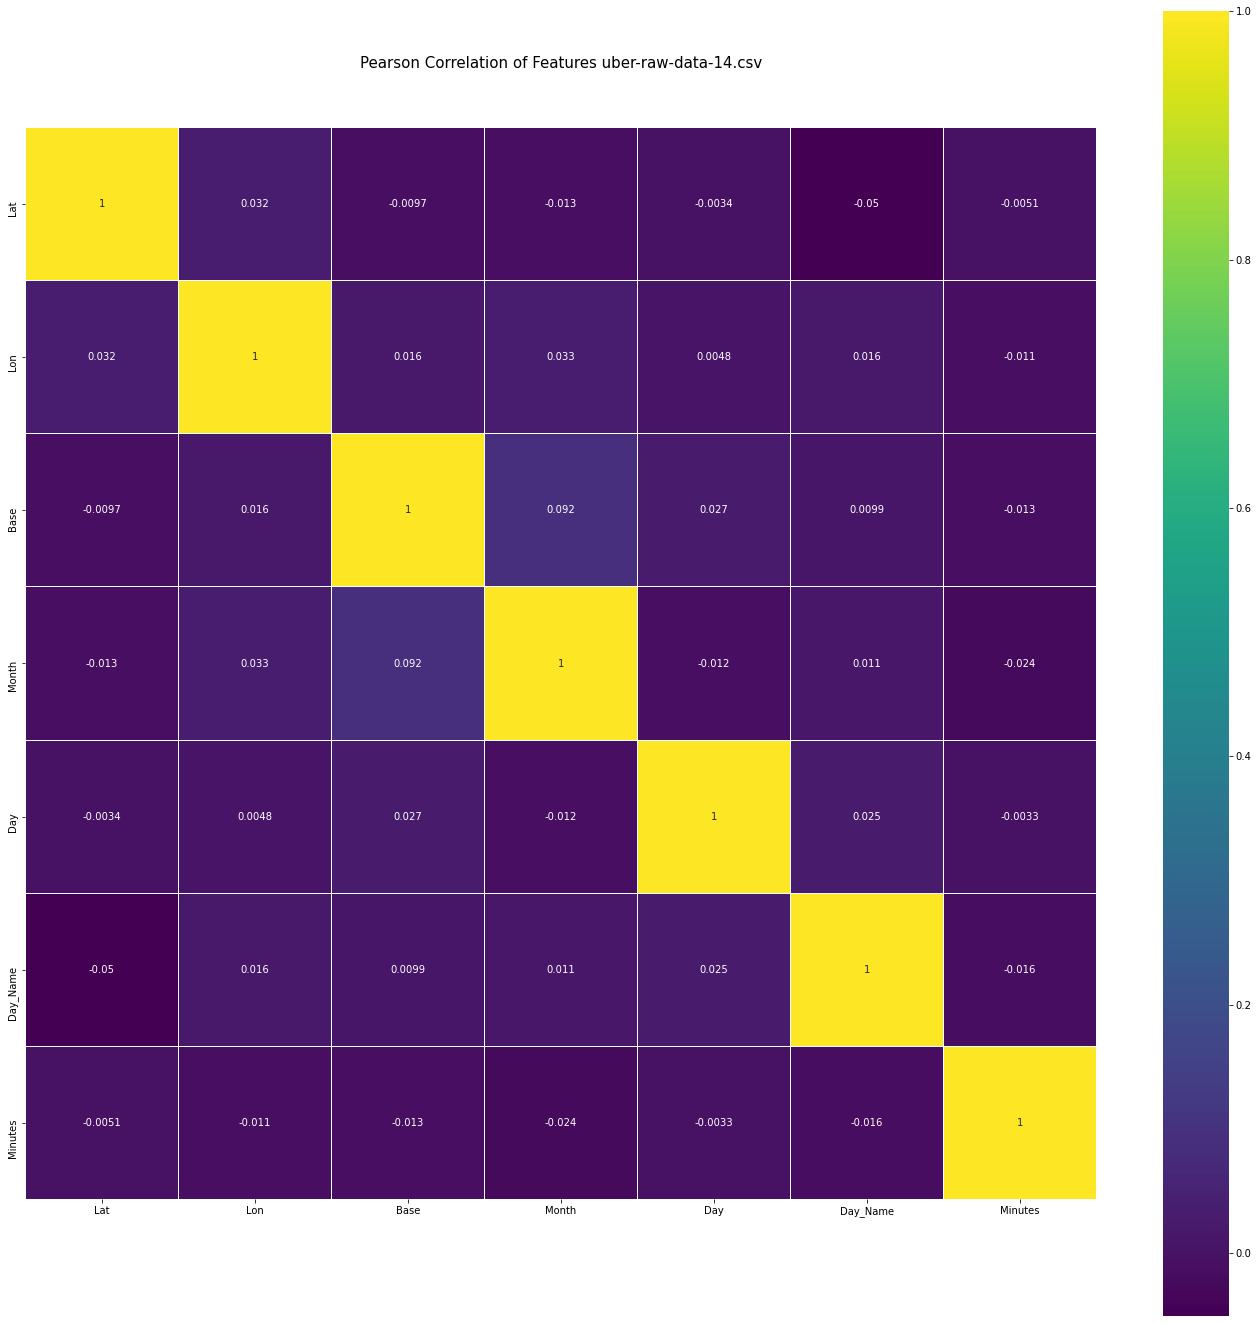

In [5]:
analyze_dataframe_basic("uber-raw-data-14.csv")


   Base  Month  Day  Day_Name  Minutes    Radius          Sin          Cos
0     0      4    1         2       11  0.034824 -2123.656533  1170.704757
1     0      4    1         2       17  0.062751 -1179.820548   649.024408
2     0      4    1         2       21  0.016206 -4565.514992  2513.414200
3     0      4    1         2       28  0.020069 -3686.163800  2030.933865
4     0      4    1         2       33  0.020156 -3670.001194  2022.206270


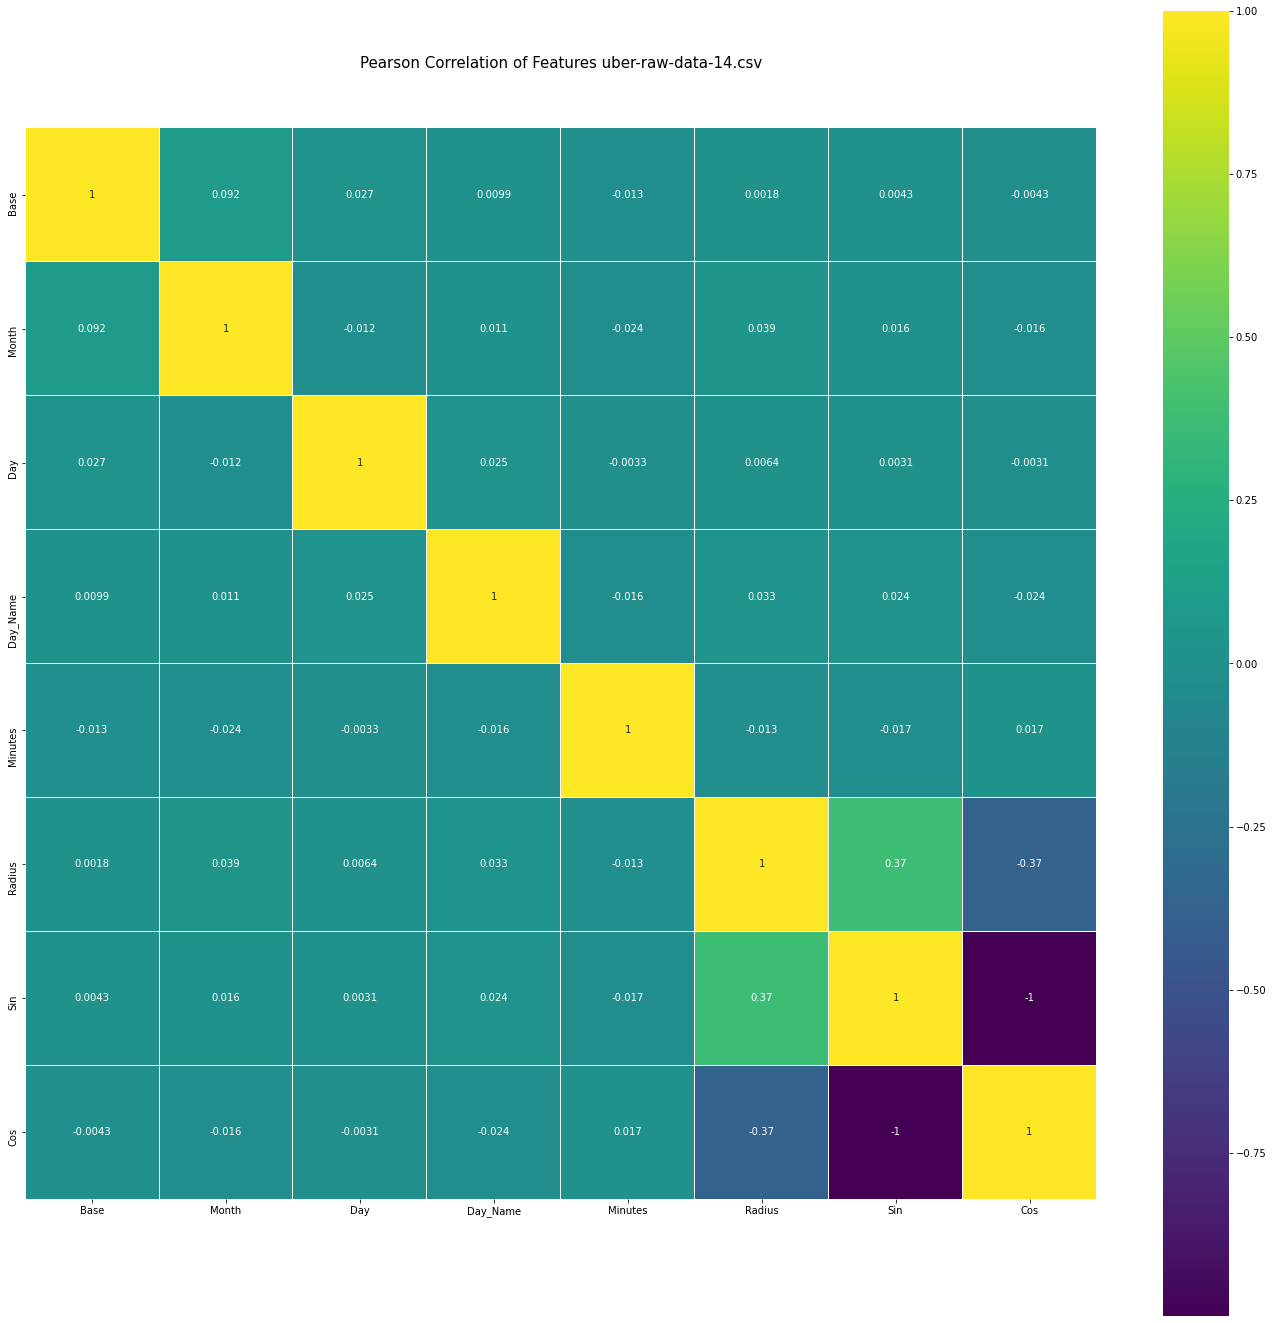

In [6]:
analyze_dataframe_radial("uber-raw-data-14.csv")

# Cab Rides Prices

In [7]:
def merge_dataframes(path="..\\data\\cab_rides\\"):
    """Function to join data from two files: cab_rides.csv, weather.xls"""
    filename_1, filename_2 = "cab_rides.csv", "weather.xls"
    prices_dataframe = pd.read_csv(path + filename_1).dropna(axis=0).reset_index(drop=True)
    prices_dataframe = prices_dataframe.drop('id', axis=1)
    weather_dataframe = pd.read_csv(path + filename_2).fillna(0).drop('time_stamp', axis=1)
    weather_dataframe = weather_dataframe.groupby('location').mean().reset_index(drop=False)
    src_weather_dataframe = weather_dataframe.rename(columns=source_columns)
    des_weather_dataframe = weather_dataframe.rename(columns=destination_columns)
    data = prices_dataframe.merge(src_weather_dataframe, on='source').merge(des_weather_dataframe, on='destination')
    return data

def onehot_encode(data, column, prefix):
    """Change singular int value into a list of 0s and 1 by onehot encode"""
    onehot_columns = pd.get_dummies(data[column], prefix=prefix)
    data = data.drop(column, axis=1)
    data = pd.concat([data, onehot_columns], axis=1)    
    return data

def refactor_data(data):
    """Function to refactor and prepare data for further actions"""
    data['cab_type'] = data['cab_type'].replace(cab_type_dict)
    data = onehot_encode(data, column='destination', prefix='destination')
    data = onehot_encode(data, column='source', prefix='source')
    data = onehot_encode(data, column='product_id', prefix='product_id')
    data = onehot_encode(data, column='name', prefix='name')
    return data    

def analyze_dataframe_basic(sourcepath="..\\data\\cab_rides\\"):
    """PCA analyze for the whole dataset"""
    data = merge_dataframes(sourcepath)
    data = refactor_data(data)
    draw_heatmap(data, "cab_rides")

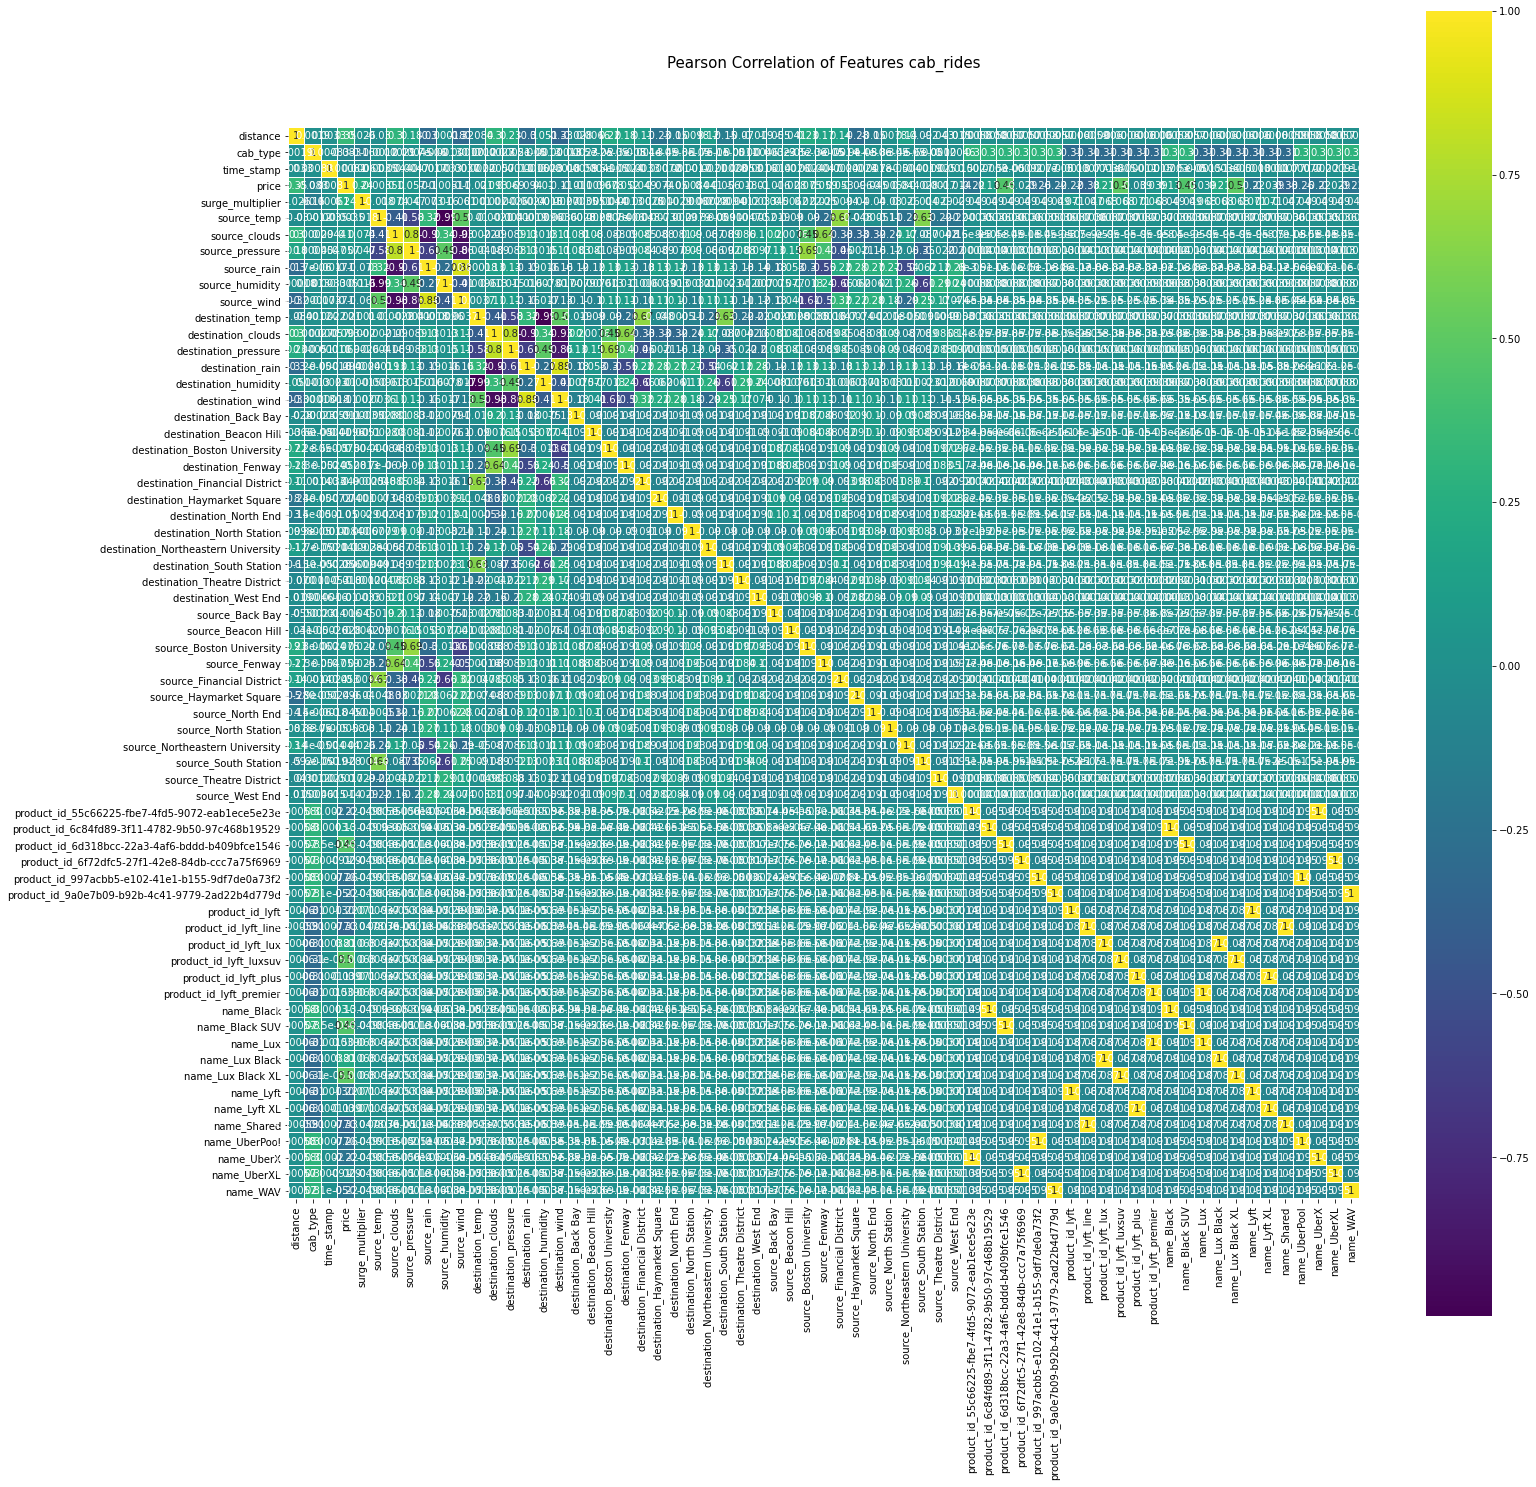

In [8]:
analyze_dataframe_basic()

# Models - predicting price of cab ride

In [30]:
def predition_score(prediction, actual_price):
    """Score model predictions - square average of the prediction error"""
    n = actual_price.shape[0]
    return np.sqrt(np.sum((np.array(prediction)-np.array(actual_price))**2)/n)

In [129]:
def split_dataframe(data):
    """Split dataframe into feature data and labels - price values"""
    y = data['price']
    X = data.drop('price', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)
    return X_train, X_test, y_train.to_numpy(), y_test.to_numpy()

def down_scale_vector(X_train, X_test, n):
    """Transform data - reduce dimentionality by using PCA"""
    pca = PCA(n_components=n).fit(X_train)
    X_train, X_test = pca.transform(X_train), pca.transform(X_test)
    return X_train, X_test

def prepare_data(sourcepath="..\\data\\cab_rides\\", pca_com=False):
    """Preprocess data for prediction models"""
    data = merge_dataframes(sourcepath)
    data = refactor_data(data)
    X_train, X_test, y_train, y_test = split_dataframe(data)
    if pca_com: X_train, X_test = down_scale_vector(X_train, X_test, pca_com)
    return X_train, X_test, y_train, y_test  

def score_model(model, X, y, n=2, m=50):
    """Score the model base on its performance on test subset"""
    if n==2:
        pred = model.predict(X)
    else:
        X = PCA(n_components=2).fit_transform(X)
    pred = pred.reshape(pred.shape[0])
    return predition_score(pred, y)

def error_analyze(model, X, y, n=2):
    """Analyze the influence of actual price on method error"""
    if n==2:
        pred = model.predict(X)
    else:
        X = PCA(n_components=2).fit_transform(X)
    prediction = pred.reshape(pred.shape[0])
    n = y.shape[0]
    minimal_price, maximal_price = int(np.min(y)), int(np.max(y))
    error = np.abs(np.array(prediction)-np.array(y))
    average_error, ns = [0] * (maximal_price - minimal_price + 1), [0] * (maximal_price - minimal_price + 1)
    
    for err, p, act_price in zip(error, prediction, y):
        idx = int(act_price) - minimal_price
        average_error[idx] = average_error[idx] * ns[idx] / (ns[idx] + 1) + err / (ns[idx] + 1)
        ns[idx] += 1
        if idx > 0:
            average_error[idx - 1] = average_error[idx - 1] * ns[idx - 1] / (ns[idx - 1] + 1) + err / (ns[idx - 1] + 1)
            ns[idx - 1] += 1 
        if idx < len(average_error) - 1:
            average_error[idx + 1] = average_error[idx + 1] * ns[idx + 1] / (ns[idx + 1] + 1) + err / (ns[idx + 1] + 1)
            ns[idx + 1] += 1
            
    std = [0] * (maximal_price - minimal_price + 1)
    for err, act_price in zip(error, y):
        idx = int(act_price) - minimal_price
        std[idx] += (err - average_error[idx]) ** 2 / ns[idx]
        if idx > 0:
            std[idx-1] += (err - average_error[idx-1]) ** 2 / ns[idx-1]
        if idx < len(average_error) - 1:
            std[idx+1] += (err - average_error[idx+1]) ** 2 / ns[idx+1]
            
    std = np.sqrt(np.array(std))
            
    plt.figure(figsize=(12, 12))
    plt.xlim((0, 100))
    plt.title("Distribution of actual prices in test subset")
    plt.xlabel("Actual price [$]")
    plt.ylabel("Number of cab rides with fixed price")
    counts, bins = np.histogram(y, bins = (maximal_price - minimal_price) // 3)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.xlim((0, 100))
    plt.title("Distribution of predicted prices in test subset")
    plt.xlabel("Predicted price [$]")
    plt.ylabel("Number of cab rides with prediced price")
    counts, bins = np.histogram(prediction, bins = (maximal_price - minimal_price) // 3)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.show()
    
    plt.figure(figsize=(12, 12))
    plt.xlim((0, 100))
    plt.title("Prediction error")
    plt.xlabel("Actual price [$]")
    plt.ylabel("Average error [$]")
    plt.errorbar([i for i in range(minimal_price, maximal_price + 1)], average_error, np.sqrt(std), linestyle='None', marker='.')
    plt.show()
    
def draw_result_3d(model, X, y, n=2, m=50):
    """Draw predictions and actual prices in 3d plot and compare them"""
    if n==2:
        pred = model.predict(X)
    else:
        X = PCA(n_components=2).fit_transform(X)
    pred = pred.reshape(pred.shape[0])
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=X[0:m,0], y=X[0:m,1], z=y[0:m], mode='markers', name="Actual price"))
    fig.add_trace(go.Scatter3d(x=X[0:m,0], y=X[0:m,1], z=pred[0:m], mode='markers', name="Predicted price"))
    fig.show()
    print("Prediction score square sum =", predition_score(pred, y))
    for i in range(m): print("actual price =", "{:5.2f}".format(y[i]), "predicted price =", \
                        "{:5.2f}".format(abs(pred[i])))
    
def linear_regression_model(sourcepath="..\\data\\cab_rides\\", n=False, m=50, \
                            do_print_ceof=False, do_draw_results=True, \
                            do_score=False, do_analyze_error = False):
    """Linear regression model - predict prices"""
    X_train, X_test, y_train, y_test = prepare_data(sourcepath, pca_com=n)
    model = LinearRegression()
    model.fit(X_train, y_train)
    if do_print_ceof: print("Coefficients:\n", model.coef_, model.intercept_)
    if do_draw_results: 
        print("Test score =", model.score(X_test, y_test))
        draw_result_3d(model, X_test, y_test, m=m)
    if do_score: return score_model(model, X_test, y_test)
    if do_analyze_error: error_analyze(model, X_test, y_test)

def gaussian_regression_model(sourcepath="..\\data\\cab_rides\\", size=20000, n=False, \
                              m=50, do_print_ceof=False, do_draw_results=True, \
                              do_score=False, do_analyze_error = False):
    """Gaussian regression model - predict prices"""
    """Giving some a priori weights is probably necessary"""
    """and may have practical usage in our project - uber"""
    """may want to give some general prediction about prices"""
    X_train, X_test, y_train, y_test = prepare_data(sourcepath, pca_com=n)
    size = min(X_train.shape[0], size)
    X_train, X_test, y_train, y_test = X_train[:size,:], X_test[:size // 4,:], y_train[:size], y_test[:size // 4]
    model = GaussianProcessRegressor()
    model.fit(X_train, y_train)
    if do_print_ceof: print("Coefficients:\n", model.L_, model.alpha_)
    if do_draw_results: 
        print("Test score =", model.score(X_test, y_test))
        draw_result_3d(model, X_test, y_test, m=m)
    if do_score: return score_model(model, X_test, y_test)
    if do_analyze_error: error_analyze(model, X_test, y_test)
        
def nn_regression_model(sourcepath="..\\data\\cab_rides\\", n=False, m=50, \
                        do_print_ceof=False, do_draw_results=True, epochs=10, \
                        do_score=False, layer_n = 1, do_analyze_error = False):
    """Neural network model predicting the prices"""
    X_train, X_test, y_train, y_test = prepare_data(sourcepath, pca_com=n)
    layer_width = 8
    if n: layer_width = int(np.sqrt(n))
    model = tf.keras.models.Sequential()
    for _ in range(layer_n): model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
    if do_score: model.fit(X_train, y_train, epochs=epochs, verbose = 0)
    else: model.fit(X_train, y_train, epochs=epochs)
    if do_draw_results: 
        print("Test score =", model.evaluate(X_test, y_test))
        draw_result_3d(model, X_test, y_test, m=m)
    if do_score: return score_model(model, X_test, y_test)
    if do_analyze_error: error_analyze(model, X_test, y_test)

In [155]:
def find_best_dimensionality_lin_reg():
    ns, scores = [65], []
    best_n, best_score = 65, linear_regression_model(do_draw_results = False, do_score = True)
    scores.append(best_score)
    for n in range(64, 2, -2):
        score = linear_regression_model(n = n, do_draw_results = False, do_score = True)
        if score < best_score: best_n, best_score = n, score
        ns.append(n)
        scores.append(score)
    plt.figure(figsize=(20, 20))
    plt.title("Linear regression score for different data dimensionality")
    plt.xlabel("n - data dimensionality")
    plt.ylabel("Linear regression score")
    plt.plot(ns, scores)
    plt.show()
    
    print(f"Best score = {best_score} for n = {best_n}")
    
    return best_n
    
def find_best_nn():
    ns, epochs, scores = [], [], []
    best_score, best_n, best_epoch, best_layer_n = inf, 0, 0, 0
    for n in range(5, 70, 10):
        for epoch in range(5, 50, 10):
            for layer_n in range(1, 6, 2):
                print(f"n = {n}, epoch = {epoch}, layer_n = {layer_n}")
                score = nn_regression_model(n = n, epochs = epoch, do_draw_results = False, \
                                            do_score = True, layer_n = layer_n)
                if score < best_score: 
                    best_n, best_score, best_epoch, best_layer_n = n, score, epoch, layer_n
                ns.append(n)
                epochs.append(epoch)
                scores.append(score)
    ax = plt.figure().add_subplot(projection='3d')
    ax.title("Linear regression score for different data dimensionality")
    ax.xlabel("n - data dimensionality")
    ax.ylabel("Linear regression score")
    ax.scatter(x, y, zs=z)
    plt.show()
    
    print(f"Best score = {best_score} for n = {best_n}, epoch = {best_epoch}, layer number = {best_layer_n + 1}")
    
    return best_n, best_epoch, best_layer_n

## Linear regression model

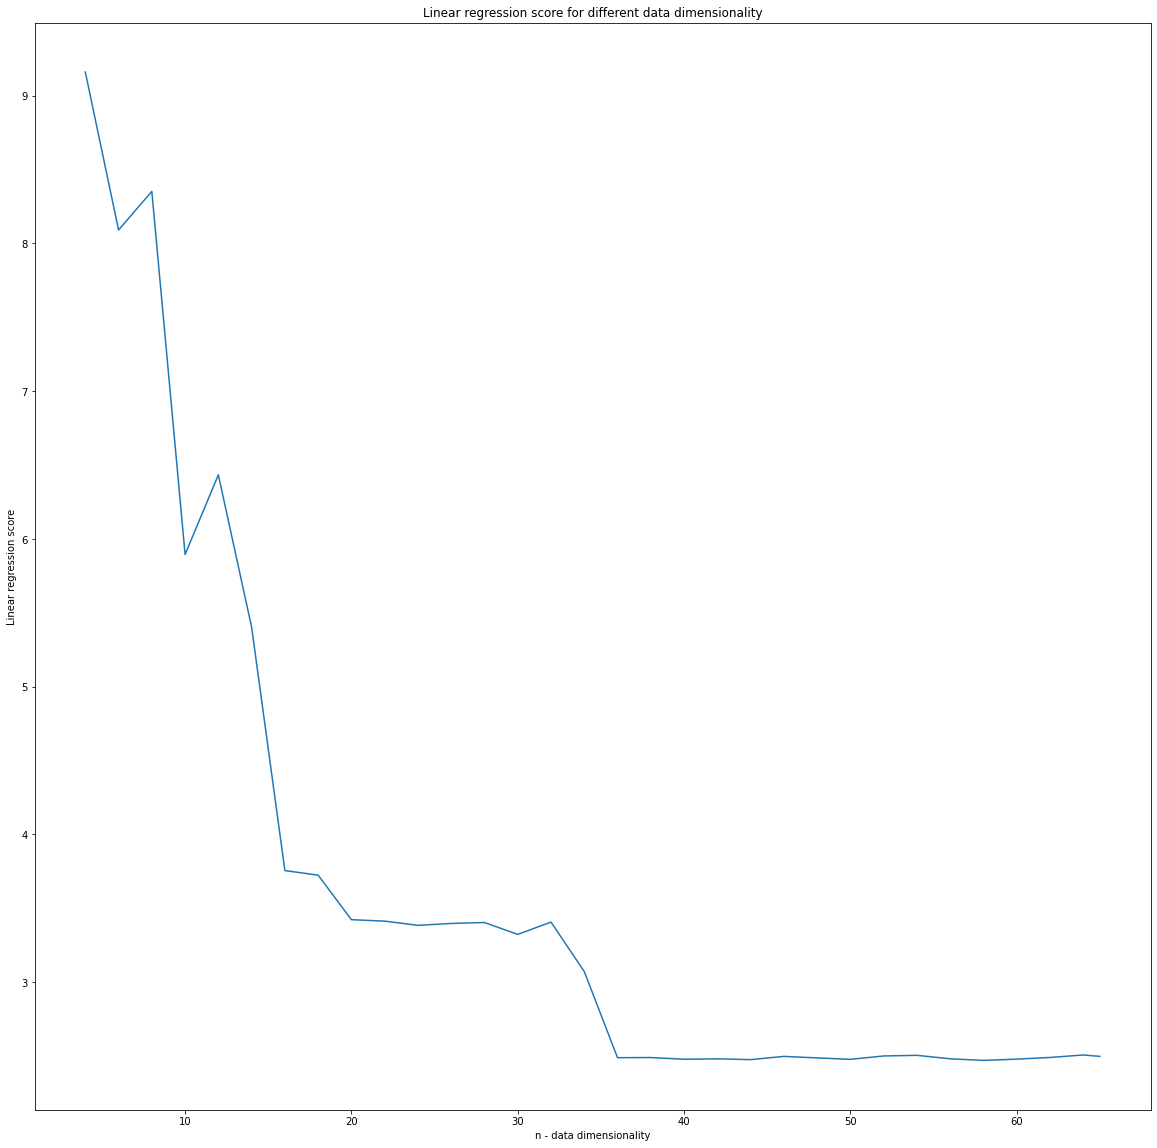

Best score = 2.4711774378072793 for n = 58


In [55]:
best_n = find_best_dimensionality_lin_reg()

### Original data

In [158]:
score = linear_regression_model()

Test score = 0.9292563512846616


Prediction score square sum = 2.4817388085720435
actual price =  8.00 predicted price = 10.45
actual price = 14.00 predicted price = 12.61
actual price = 55.00 predicted price = 45.77
actual price =  7.00 predicted price =  6.03
actual price = 26.00 predicted price = 28.38
actual price = 16.50 predicted price = 16.73
actual price = 10.50 predicted price = 11.32
actual price =  8.50 predicted price =  9.24
actual price =  8.00 predicted price =  7.28
actual price = 12.00 predicted price = 11.46
actual price = 30.00 predicted price = 30.87
actual price = 27.50 predicted price = 26.80
actual price = 11.00 predicted price = 12.45
actual price = 13.50 predicted price = 13.91
actual price = 65.00 predicted price = 47.54
actual price =  7.50 predicted price =  8.35
actual price = 19.50 predicted price = 21.43
actual price = 10.50 predicted price = 11.33
actual price =  9.50 predicted price =  8.65
actual price =  7.50 predicted price =  5.81
actual price = 11.00 predicted price = 12.31
actual

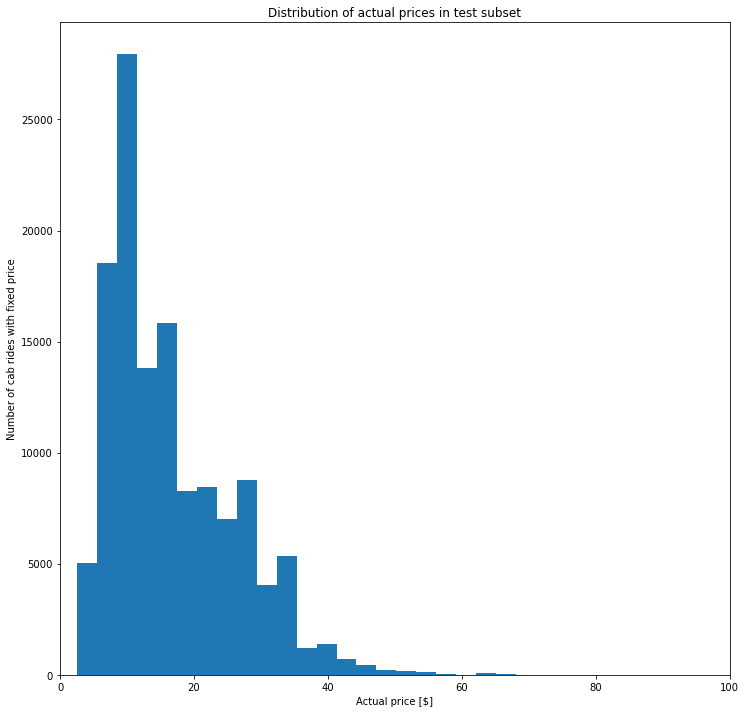

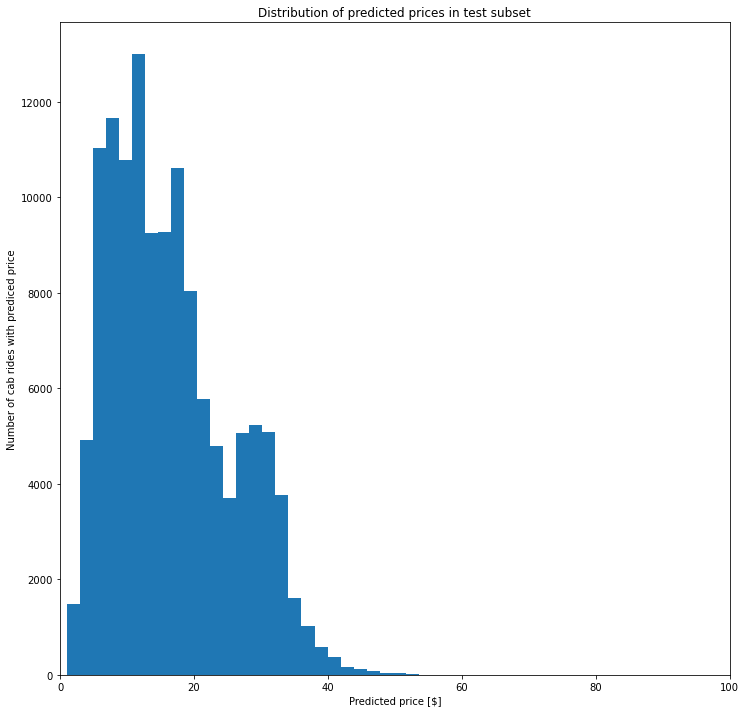

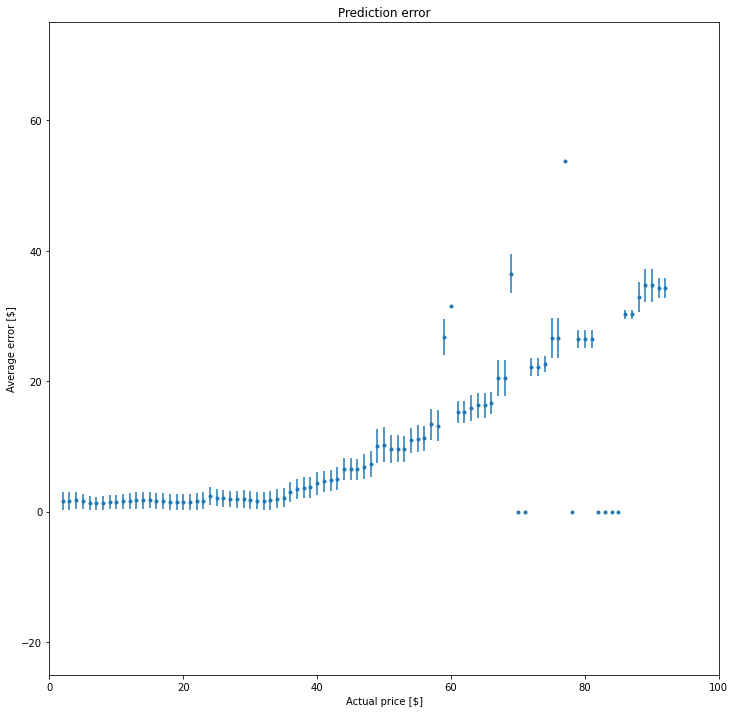

In [130]:
score = linear_regression_model(do_draw_results=False, do_analyze_error=True)

### Data with reduced dimensionality

In [159]:
score = linear_regression_model(n=best_n)

Test score = 0.9290976075989729


Prediction score square sum = 2.483550442752206
actual price =  3.50 predicted price =  6.18
actual price = 10.50 predicted price = 11.57
actual price =  9.50 predicted price = 10.66
actual price =  7.50 predicted price =  7.17
actual price = 11.50 predicted price = 13.37
actual price = 19.50 predicted price = 21.12
actual price = 13.50 predicted price = 13.73
actual price = 14.00 predicted price = 15.42
actual price =  9.00 predicted price =  9.02
actual price = 19.50 predicted price = 18.22
actual price = 13.50 predicted price = 11.17
actual price =  7.00 predicted price =  7.20
actual price = 26.00 predicted price = 27.73
actual price =  7.00 predicted price =  6.38
actual price =  6.00 predicted price =  6.34
actual price =  5.00 predicted price =  3.79
actual price = 10.50 predicted price = 11.04
actual price =  7.00 predicted price =  9.02
actual price = 11.00 predicted price = 10.77
actual price = 34.00 predicted price = 27.73
actual price =  9.00 predicted price =  8.47
actual 

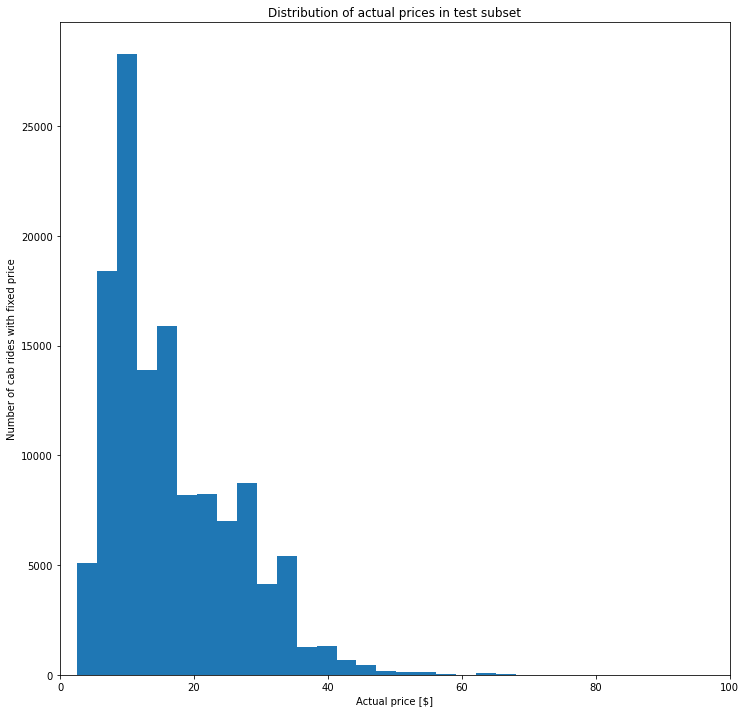

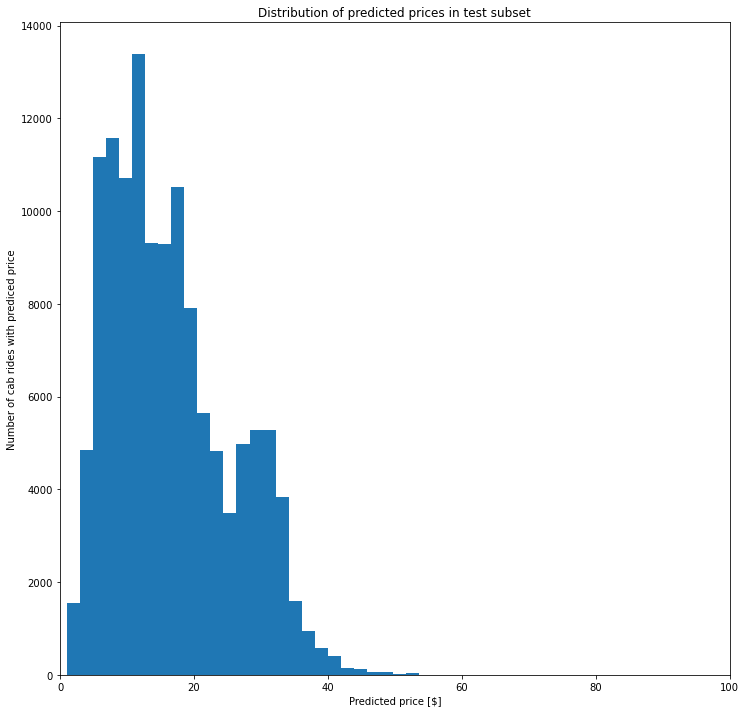

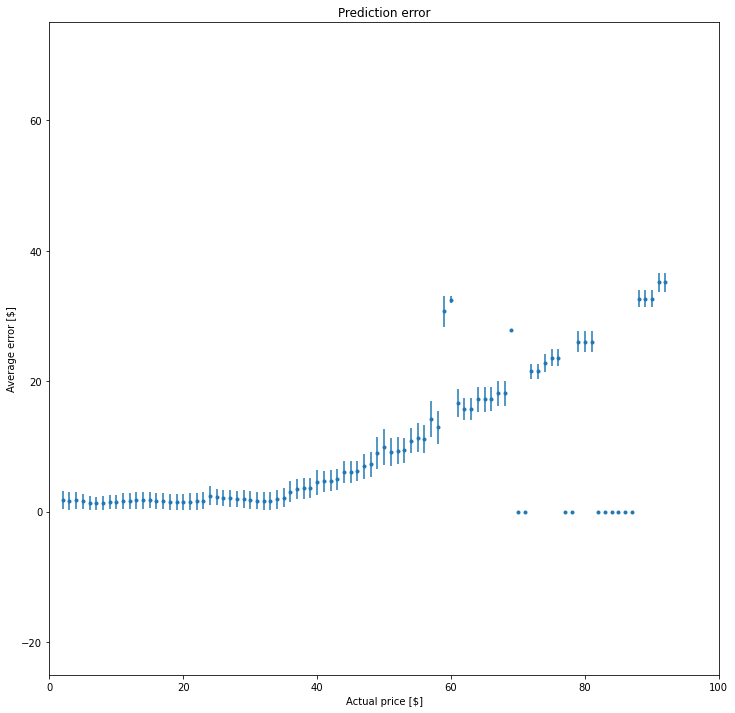

In [131]:
score = linear_regression_model(n=best_n, do_draw_results=False, do_analyze_error=True)

## Gaussian regression model

In [58]:
score = gaussian_regression_model(size=20000)

Test score = -3832.0249933568375


Prediction score square sum = 558.0111586712379
actual price =  8.00 predicted price =  7.04
actual price = 34.00 predicted price = 35.65
actual price = 10.50 predicted price = 64.14
actual price = 10.50 predicted price =  9.71
actual price = 10.50 predicted price = 22.16
actual price =  7.00 predicted price =  1.71
actual price =  9.00 predicted price = 10.75
actual price = 13.50 predicted price =  0.92
actual price = 27.50 predicted price = 29.17
actual price =  9.00 predicted price =  8.03
actual price =  7.00 predicted price =  7.32
actual price = 16.50 predicted price = 16.12
actual price = 27.50 predicted price = 15.00
actual price =  3.50 predicted price =  3.31
actual price = 22.50 predicted price = 34.88
actual price = 26.50 predicted price = 27.12
actual price = 23.00 predicted price = 20.93
actual price = 19.50 predicted price = 72.89
actual price = 11.00 predicted price = 321.88
actual price = 20.50 predicted price = 15.79
actual price =  8.50 predicted price =  8.81
actual

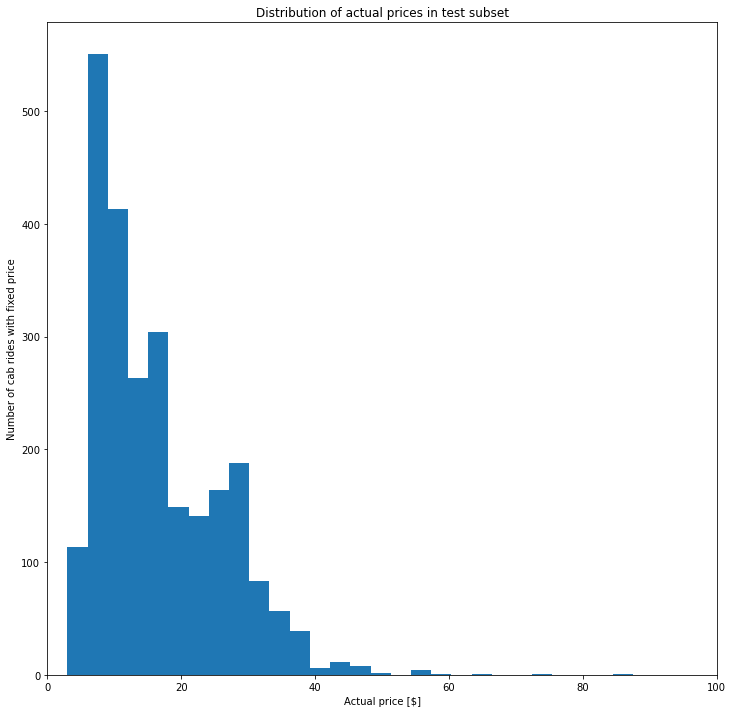

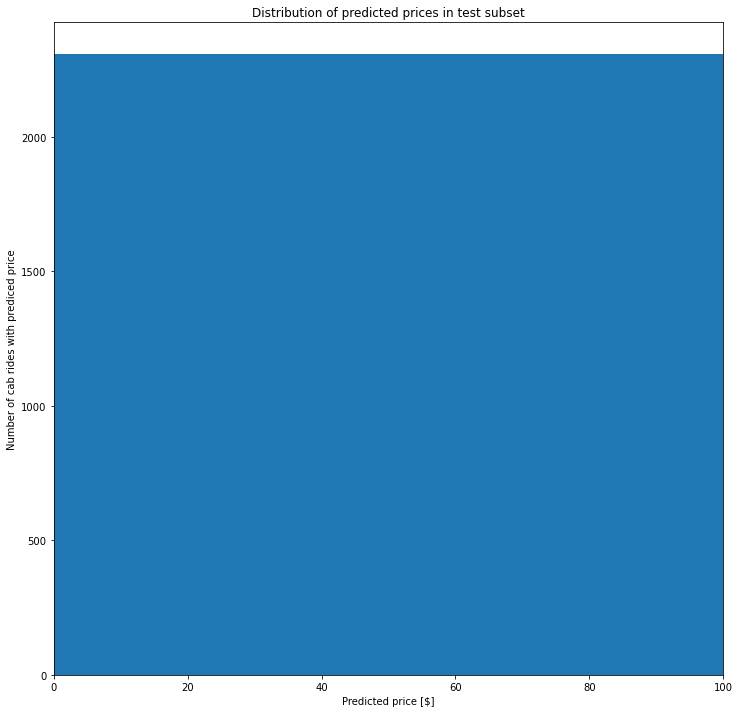

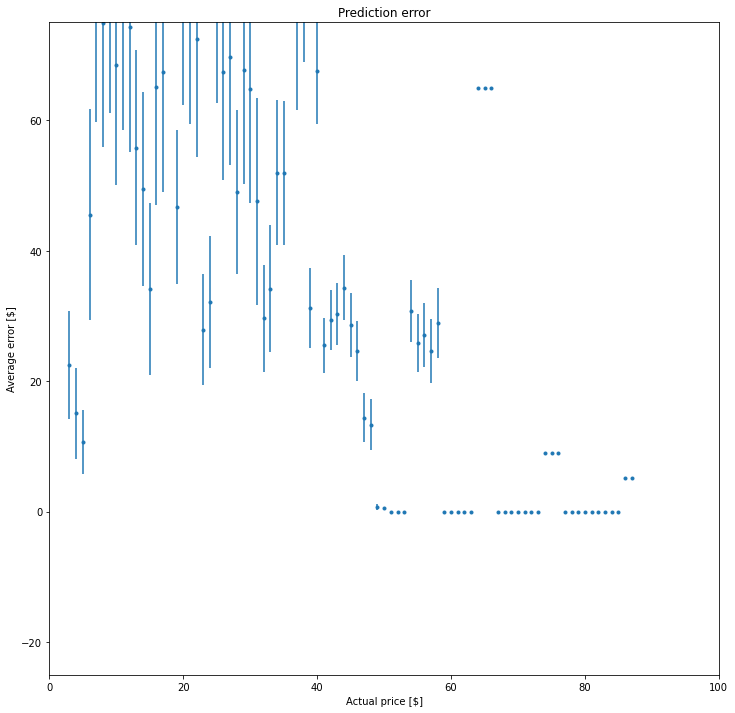

In [134]:
score = gaussian_regression_model(size=10000, do_draw_results=False, do_analyze_error=True)

## Neural Network model

In [160]:
best_n, best_epoch, best_layer_n = 50, 10, 1
# best_n, best_epoch, best_layer_n = find_best_nn()

In [161]:
score = nn_regression_model(n = best_n, epochs = best_epoch, layer_n = best_layer_n)

Epoch 1/10
15950/15950 [==============================] - 24s 1ms/step - loss: 10.7796 - mae: 1.7738
Epoch 2/10
15950/15950 [==============================] - 23s 1ms/step - loss: 3.2386 - mae: 1.2089
Epoch 3/10
15950/15950 [==============================] - 24s 1ms/step - loss: 3.1877 - mae: 1.1984
Epoch 4/10
15950/15950 [==============================] - 24s 2ms/step - loss: 3.1738 - mae: 1.1939
Epoch 5/10
15950/15950 [==============================] - 25s 2ms/step - loss: 3.1607 - mae: 1.1898
Epoch 6/10
15950/15950 [==============================] - 25s 2ms/step - loss: 3.1467 - mae: 1.1866
Epoch 7/10
15950/15950 [==============================] - 24s 2ms/step - loss: 3.1327 - mae: 1.1837
Epoch 8/10
15950/15950 [==============================] - 27s 2ms/step - loss: 3.1205 - mae: 1.1801
Epoch 9/10
15950/15950 [==============================] - 23s 1ms/step - loss: 3.1153 - mae: 1.1789
Epoch 10/10
3988/3988 [==============================] - 5s 1ms/step - loss: 3.1650 - mae: 1.1932
T

Prediction score square sum = 1.7790484710138679
actual price = 19.50 predicted price = 21.44
actual price = 22.50 predicted price = 20.32
actual price = 12.50 predicted price =  5.78
actual price = 19.50 predicted price = 23.04
actual price =  8.50 predicted price =  9.83
actual price = 39.50 predicted price = 41.12
actual price = 11.50 predicted price = 10.49
actual price = 13.50 predicted price = 14.93
actual price = 19.50 predicted price = 18.17
actual price = 13.50 predicted price = 14.87
actual price = 32.50 predicted price = 34.36
actual price = 10.50 predicted price = 10.78
actual price =  8.00 predicted price =  9.07
actual price = 34.00 predicted price = 33.52
actual price = 19.00 predicted price = 18.93
actual price =  7.00 predicted price =  5.97
actual price = 15.00 predicted price = 15.59
actual price = 65.00 predicted price = 60.30
actual price = 25.50 predicted price = 21.55
actual price =  7.00 predicted price =  6.82
actual price =  7.00 predicted price =  5.11
actual

Epoch 1/10
15950/15950 [==============================] - 23s 1ms/step - loss: 11.8548 - mae: 1.8187
Epoch 2/10
15950/15950 [==============================] - 23s 1ms/step - loss: 3.3499 - mae: 1.2275
Epoch 3/10
15950/15950 [==============================] - 24s 2ms/step - loss: 3.2668 - mae: 1.2098
Epoch 4/10
15950/15950 [==============================] - 24s 2ms/step - loss: 3.2328 - mae: 1.2036
Epoch 5/10
15950/15950 [==============================] - 24s 2ms/step - loss: 3.2184 - mae: 1.2008
Epoch 6/10
15950/15950 [==============================] - 26s 2ms/step - loss: 3.1997 - mae: 1.1963
Epoch 7/10
15950/15950 [==============================] - 25s 2ms/step - loss: 3.1883 - mae: 1.1932
Epoch 8/10
15950/15950 [==============================] - 22s 1ms/step - loss: 3.1832 - mae: 1.1924
Epoch 9/10
15950/15950 [==============================] - 21s 1ms/step - loss: 3.1755 - mae: 1.1903
Epoch 10/10
3988/3988 [==============================] - 4s 942us/step


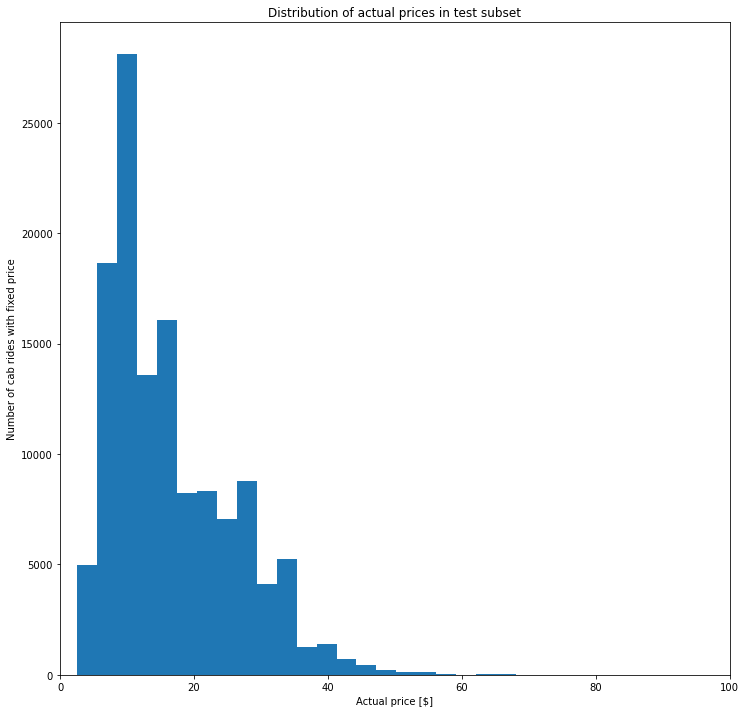

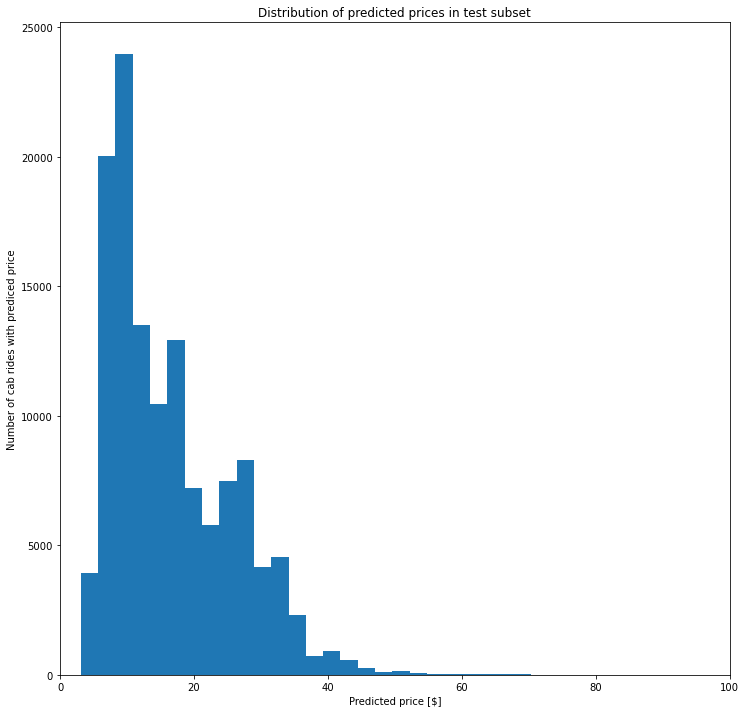

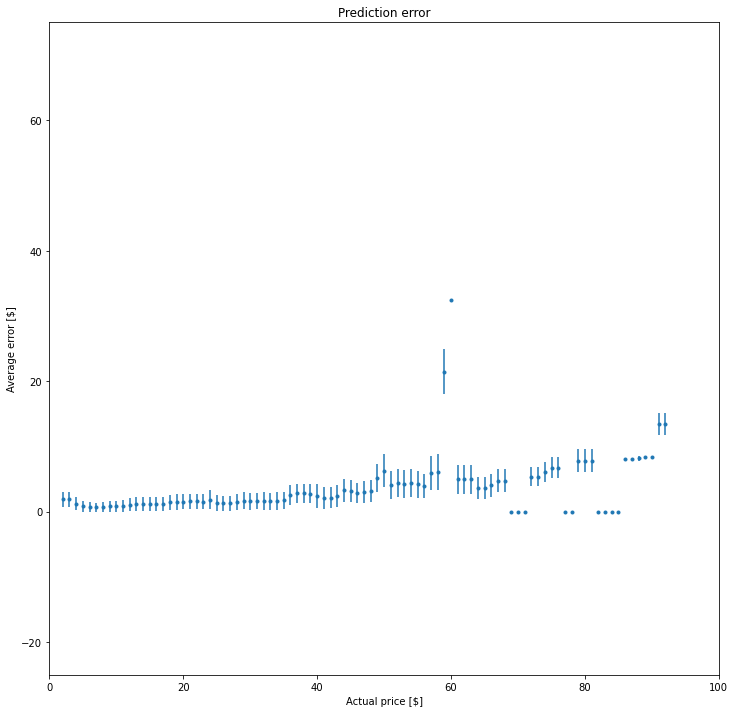

In [162]:
score = nn_regression_model(n = best_n, epochs = best_epoch, layer_n = best_layer_n, do_draw_results=False, do_analyze_error=True)

# Cab rides analyze with exact condition

In [168]:
def init_dict(weather_dataframe):
    loc_dict = dict()
    for loc in np.unique(weather_dataframe['location']): 
        loc_dict[loc] = []
    return loc_dict

def fill_dict(loc_dict, weather_dataframe):
    for row in weather_dataframe.to_numpy(): 
        loc_dict[row[1]].append(row)
    return loc_dict
 
def sort_cond(loc_dict):
    for loc, rows in loc_dict.items(): 
        rows.sort(key=lambda x: x[5])
    return loc_dict

def find_condition(loc_dict, row, i):
    t, conditions = row[2], loc_dict[row[i]]
    a, b = 0, len(conditions) - 1
    while a < b - 1:
        c = (a + b) // 2
        if conditions[c][5] < t: a = c
        else: b = c
    return conditions[c]    

def append_rows(loc_dict, prices_dataframe):
    data, data_merged = prices_dataframe.to_numpy(), []
    for row in data:
        row = np.append(row, find_condition(loc_dict, row, 4), 0)
        data_merged.append(np.append(row, find_condition(loc_dict, row, 3), 0))
    return data_merged

def join_dataframes(path="..\\data\\cab_rides\\"):
    """Function to join data from two files: cab_rides.csv, weather.xls"""
    filename_1, filename_2 = "cab_rides.csv", "weather.xls"
    prices_dataframe = pd.read_csv(path + filename_1).dropna(axis=0).reset_index(drop=True)
    prices_dataframe = prices_dataframe.drop('id', axis=1)
    prices_dataframe['time_stamp'] = prices_dataframe['time_stamp'] // 1000
    weather_dataframe = pd.read_csv(path + filename_2).fillna(0)
    loc_dict = init_dict(weather_dataframe)
    loc_dict = fill_dict(loc_dict, weather_dataframe)
    loc_dict = sort_cond(loc_dict)
    data_merged = append_rows(loc_dict, prices_dataframe)
    df = pd.DataFrame(np.array(data_merged), columns = names_list)
    df = df.drop('destination_location', axis=1).drop('source_location', axis=1)
    df = df.drop('destination_time_stamp', axis=1).drop('source_time_stamp', axis=1)
    return df

def preprocess_data(sourcepath="..\\data\\cab_rides\\", pca_com=False):
    """Preprocess data for prediction models"""
    data = join_dataframes(sourcepath)
    data = refactor_data(data)
    X_train, X_test, y_train, y_test = split_dataframe(data)
    if pca_com: X_train, X_test = down_scale_vector(X_train, X_test, pca_com)
    return X_train, X_test, y_train, y_test
    
def analyze_dataframe_joined(sourcepath="..\\data\\cab_rides\\"):
    """PCA analyze for the whole dataset"""
    data = join_dataframes(sourcepath)
    data = refactor_data(data)
    draw_heatmap(data, "cab_rides")

In [169]:
def linear_regression_model_condition(sourcepath="..\\data\\cab_rides\\", n=False, \
                                      do_print_ceof=False, do_draw_results=True, \
                                      do_score = False, do_analyze_error=False):
    """Linear regression model - predict prices"""
    X_train, X_test, y_train, y_test = preprocess_data(sourcepath, pca_com=n)
    model = LinearRegression()
    model.fit(X_train, y_train)
    if do_print_ceof: print("Coefficients:\n", model.coef_, model.intercept_)
    print("Test score =", model.score(X_test, y_test))
    if do_draw_results: draw_result_3d(model, X_test, y_test)  
    if do_score: return score_model(model, X_test, y_test)
    if do_analyze_error: error_analyze(model, X_test, y_test)

def gaussian_regression_model_condition(sourcepath="..\\data\\cab_rides\\", size=20000, n=False, \
                                        do_print_ceof=False, do_draw_results=True, \
                                        do_score = False, do_analyze_error=False):
    """Gaussian regression model - predict prices"""
    """Giving some a priori weights is probably necessary"""
    """and may have practical usage in our project - uber"""
    """may want to give some general prediction about prices"""
    X_train, X_test, y_train, y_test = preprocess_data(sourcepath, pca_com=n)
    size = min(X_train.shape[0], size)
    X_train, X_test, y_train, y_test = X_train[:size,:], X_test[:size // 4,:], y_train[:size], y_test[:size // 4]
    model = GaussianProcessRegressor()
    model.fit(X_train, y_train)
    if do_print_ceof: print("Coefficients:\n", model.L_, model.alpha_)
    print("Test score =", model.score(X_test, y_test))
    if do_draw_results: draw_result_3d(model, X_test, y_test)
    if do_score: return score_model(model, X_test, y_test)
    if do_analyze_error: error_analyze(model, X_test, y_test)
        
def nn_regression_model_condition(sourcepath="..\\data\\cab_rides\\", size=20000, n=False, \
                                  do_print_ceof=False, do_draw_results=True, epochs=10, \
                                  do_score = False, layer_n = 1, do_analyze_error=False):
    """Neural network model predicting the prices"""
    X_train, X_test, y_train, y_test = preprocess_data(sourcepath, pca_com=n)
    X_train, X_test, y_train, y_test = X_train.astype('float32'), X_test.astype('float32'), y_train.astype('float32'), y_test.astype('float32')
    layer_width = 8
    if n: layer_width = int(np.sqrt(n))
    model = tf.keras.models.Sequential()
    for _ in range(layer_n): model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))
    model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
    if do_score: model.fit(X_train, y_train, epochs=epochs, verbose = 0)
    else: model.fit(X_train, y_train, epochs=epochs)
    if do_draw_results: 
        print("Test score =", model.evaluate(X_test, y_test))
        draw_result_3d(model, X_test, y_test)
    if do_score: return score_model(model, X_test, y_test)
    if do_analyze_error: error_analyze(model, X_test, y_test)    

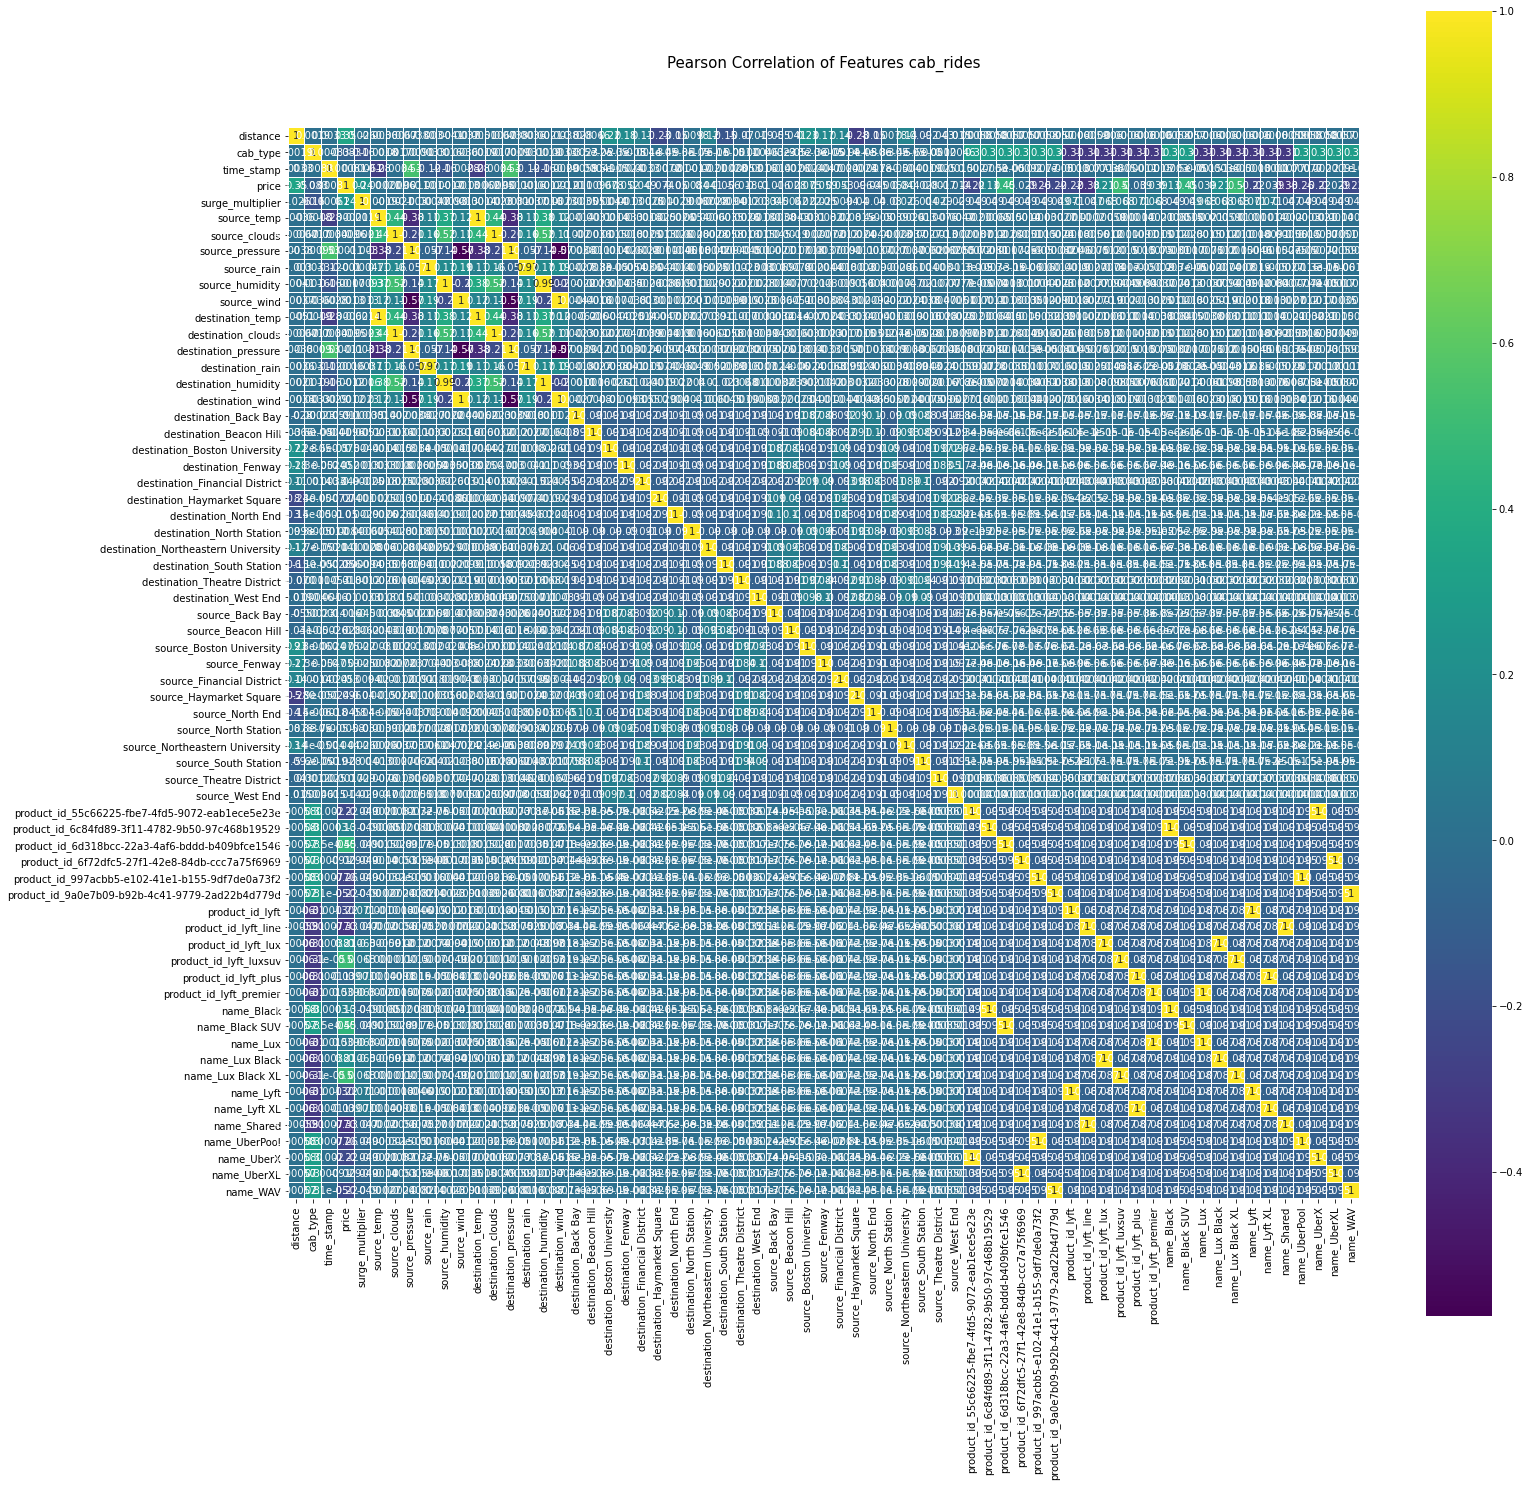

In [47]:
analyze_dataframe_joined()

In [170]:
def find_best_dimensionality_lin_reg_condition():
    ns, scores = [65], []
    best_n, best_score = 65, linear_regression_model_condition(do_draw_results = False, do_score = True)
    scores.append(best_score)
    for n in range(64, 2, -2):
        score = linear_regression_model_condition(n = n, do_draw_results = False, do_score = True)
        if score < best_score: best_n, best_score = n, score
        ns.append(n)
        scores.append(score)
    plt.title("Linear regression score for different data dimensionality")
    plt.xlabel("n - data dimensionality")
    plt.ylabel("Linear regression score")
    plt.plot(ns, scores)
    plt.show()
    
    print(f"Best score = {best_score} for n = {best_n}")
    
    return best_n
    
def find_best_nn_condition():
    ns, epochs, scores = [], [], []
    best_score, best_n, best_epoch, best_layer_n = inf, 0, 0, 0
    for n in range(5, 70, 10):
        for epoch in range(5, 50, 10):
            for layer_n in range(1, 6, 2):
                print(f"n = {n}, epoch = {epoch}, layer_n = {layer_n}")
                score = nn_regression_model_condition(n = n, epochs = epoch, do_draw_results = False, \
                                                      do_score = True, layer_n = layer_n)
                if score < best_score: best_n, best_epoch, best_layer_n, best_score = n, sepoch, layer_n, score
                ns.append(n)
                epochs.append(epoch)
                scores.append(score)
    ax = plt.figure().add_subplot(projection='3d')
    ax.title("Linear regression score for different data dimensionality")
    ax.xlabel("n - data dimensionality")
    ax.ylabel("Linear regression score")
    ax.scatter(x, y, zs=z)
    plt.show()
    
    print(f"Best score = {best_score} for n = {best_n}, epoch = {best_epoch} and number of layers = {best_layer_n}")
    
    return best_n, best_epoch, best_layer_n

## Linear regression model

Test score = 0.9288300945999465
Test score = 0.9282103198876183
Test score = 0.9282587768681987
Test score = 0.9273255432210563
Test score = 0.9290115039311029
Test score = 0.929768783459983
Test score = 0.9275493462116621
Test score = 0.9292737658191759
Test score = 0.9286929647787335
Test score = 0.9294321944495758
Test score = 0.9285992260821563
Test score = 0.9287619118919128
Test score = 0.9290341854490365
Test score = 0.9282821448870184
Test score = 0.9013647165334558
Test score = 0.8858006451504357
Test score = 0.8860204662775711
Test score = 0.8869570741262514
Test score = 0.8863288742047701
Test score = 0.8862190694779192
Test score = 0.8868098076993965
Test score = 0.8832081324675678
Test score = 0.8833125302698565
Test score = 0.8836767915064667
Test score = 0.8803848746752866
Test score = 0.8821041428806587
Test score = 0.7874676959657259
Test score = 0.5608562410980745
Test score = 0.546217050624016
Test score = 0.31297900740399254
Test score = 0.17895279617011295
Test sco

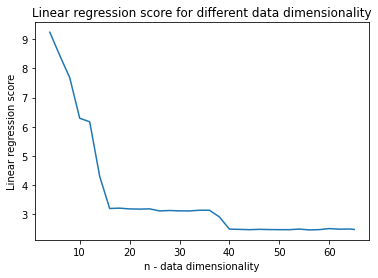

Best score = 2.47135978645643 for n = 56


In [141]:
best_n = find_best_dimensionality_lin_reg_condition()

### Original data

In [171]:
linear_regression_model_condition()

Test score = 0.9298273580130121


Prediction score square sum = 2.472848064277251
actual price = 11.00 predicted price = 11.86
actual price = 19.50 predicted price = 19.97
actual price = 11.00 predicted price = 10.05
actual price = 10.50 predicted price = 11.31
actual price =  5.50 predicted price =  4.46
actual price = 23.00 predicted price = 22.54
actual price =  9.00 predicted price = 10.23
actual price = 32.50 predicted price = 22.27
actual price =  7.00 predicted price =  6.18
actual price = 30.50 predicted price = 27.19
actual price =  7.00 predicted price =  8.10
actual price = 16.50 predicted price = 16.54
actual price = 42.50 predicted price = 35.87
actual price = 27.50 predicted price = 27.19
actual price =  3.50 predicted price =  2.06
actual price =  7.00 predicted price =  6.91
actual price =  5.00 predicted price =  3.31
actual price = 13.50 predicted price = 14.86
actual price = 16.50 predicted price = 18.36
actual price = 11.00 predicted price = 13.24
actual price =  7.50 predicted price =  8.90
actual 

Test score = 0.9287821313795862


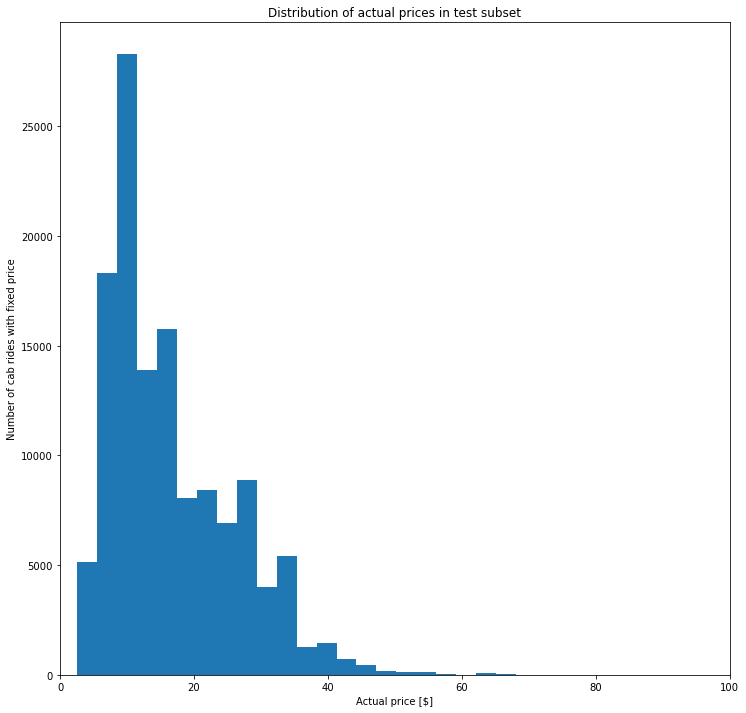

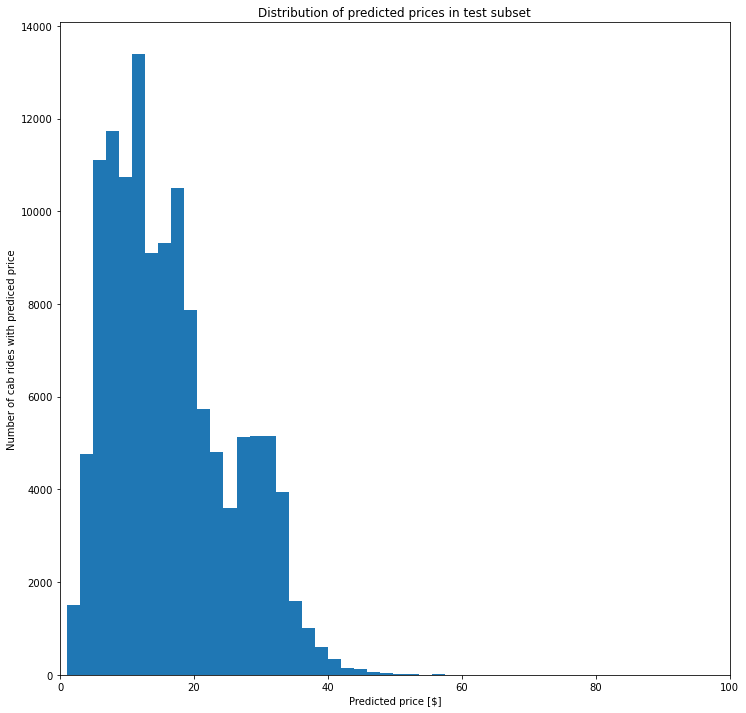

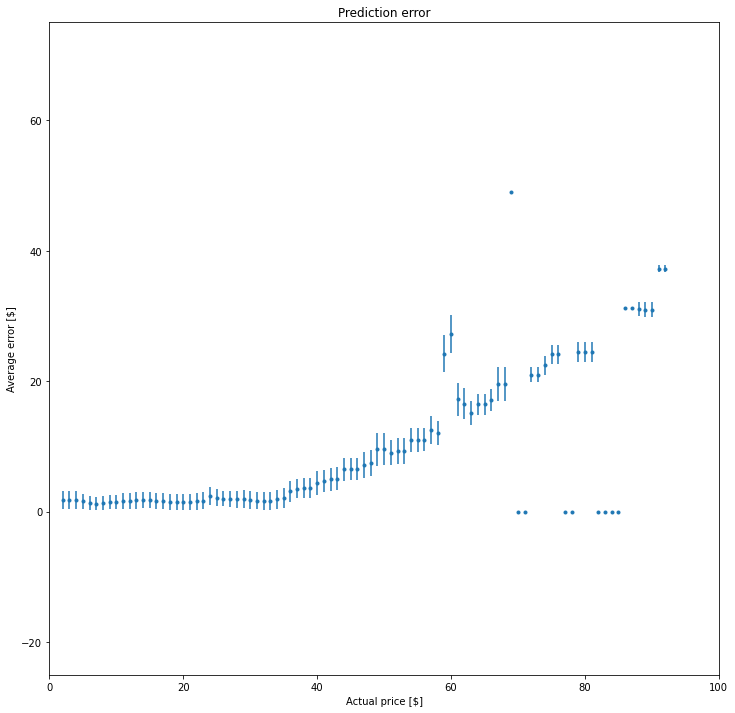

In [143]:
linear_regression_model_condition(do_draw_results=False, do_analyze_error=True)

### Reduced dimensionality

In [172]:
best_n = 58
linear_regression_model_condition(n=best_n)

Test score = 0.927451643935678


Prediction score square sum = 2.5168815070755395
actual price = 16.50 predicted price = 16.96
actual price = 22.50 predicted price = 22.10
actual price = 19.50 predicted price = 18.84
actual price = 10.50 predicted price = 10.43
actual price = 16.50 predicted price = 15.75
actual price = 26.00 predicted price = 25.26
actual price =  9.00 predicted price =  6.35
actual price = 26.00 predicted price = 27.07
actual price = 10.50 predicted price = 13.00
actual price =  9.50 predicted price = 11.57
actual price =  7.00 predicted price =  6.47
actual price =  9.50 predicted price = 11.13
actual price =  6.50 predicted price =  5.96
actual price =  7.00 predicted price =  7.65
actual price = 29.50 predicted price = 30.94
actual price =  7.00 predicted price =  8.81
actual price = 19.50 predicted price = 19.87
actual price =  7.00 predicted price =  4.70
actual price = 32.50 predicted price = 26.99
actual price = 19.50 predicted price = 21.77
actual price = 19.50 predicted price = 17.57
actual

Test score = 0.9288730783078233


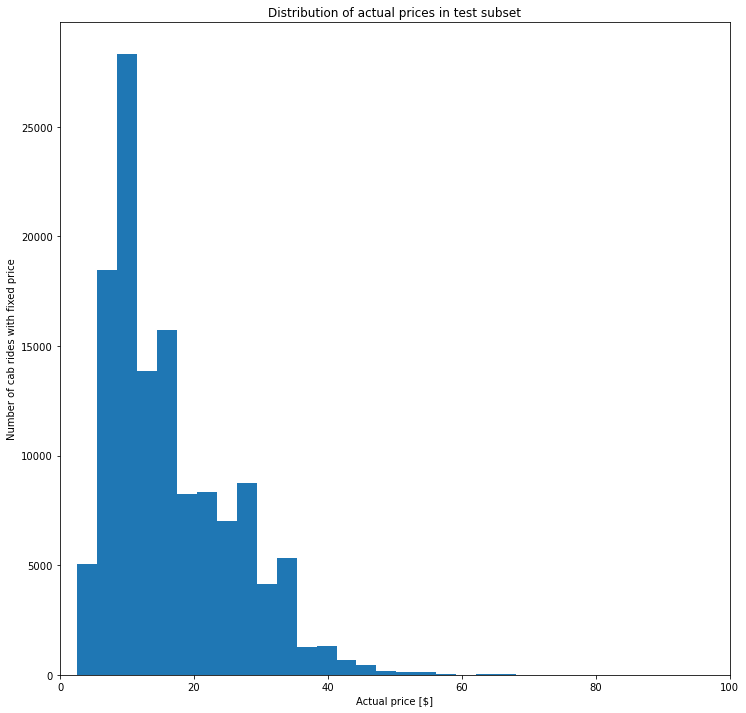

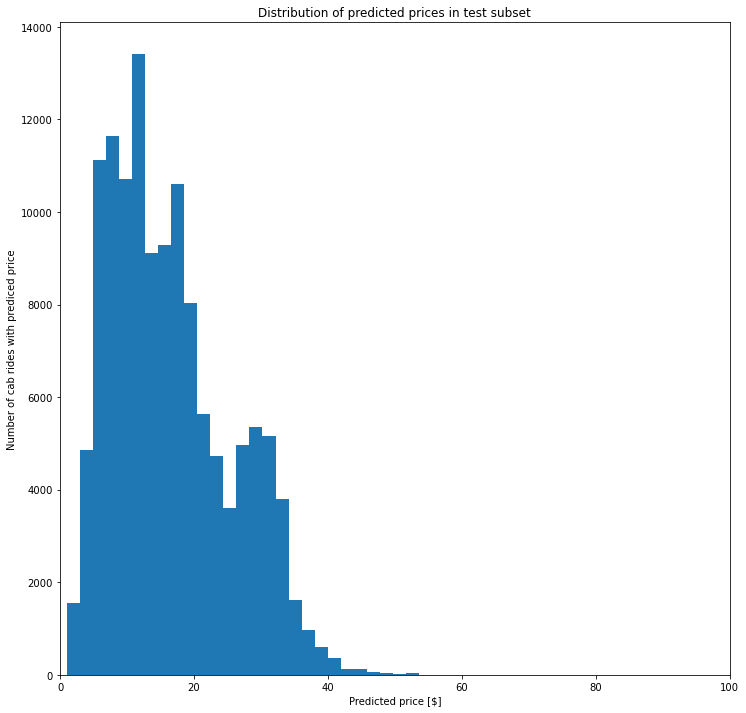

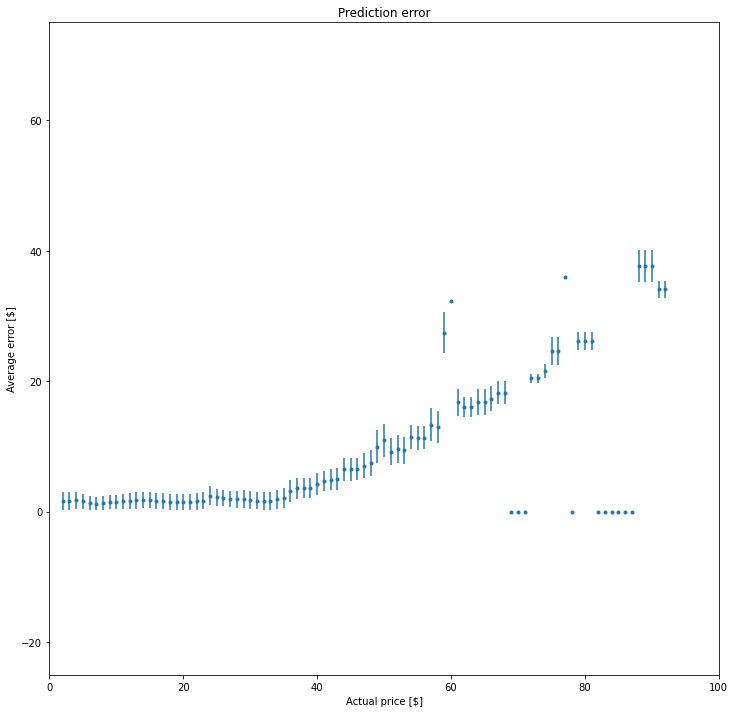

In [145]:
linear_regression_model_condition(n=best_n, do_draw_results=False, do_analyze_error=True)

## Gaussian regression model

In [146]:
gaussian_regression_model_condition(size=10000)

Test score = -9.12319115350425


Prediction score square sum = 29.129873022745095
actual price = 26.00 predicted price =  2.87
actual price =  6.00 predicted price =  2.04
actual price = 11.00 predicted price =  0.70
actual price = 16.50 predicted price =  0.20
actual price = 30.00 predicted price =  0.81
actual price = 28.50 predicted price = 10.70
actual price =  5.50 predicted price =  0.18
actual price = 19.50 predicted price =  2.26
actual price = 32.50 predicted price =  0.12
actual price = 10.50 predicted price =  8.64
actual price = 27.50 predicted price =  1.04
actual price = 10.50 predicted price =  0.23
actual price = 12.00 predicted price =  0.77
actual price = 11.50 predicted price =  0.86
actual price =  7.00 predicted price =  0.29
actual price =  7.00 predicted price =  0.00
actual price = 32.50 predicted price = 34.01
actual price = 16.50 predicted price = 13.44
actual price = 32.50 predicted price = 16.35
actual price = 27.50 predicted price =  2.49
actual price = 30.00 predicted price = 33.97
actual

Test score = -10.991656661672396


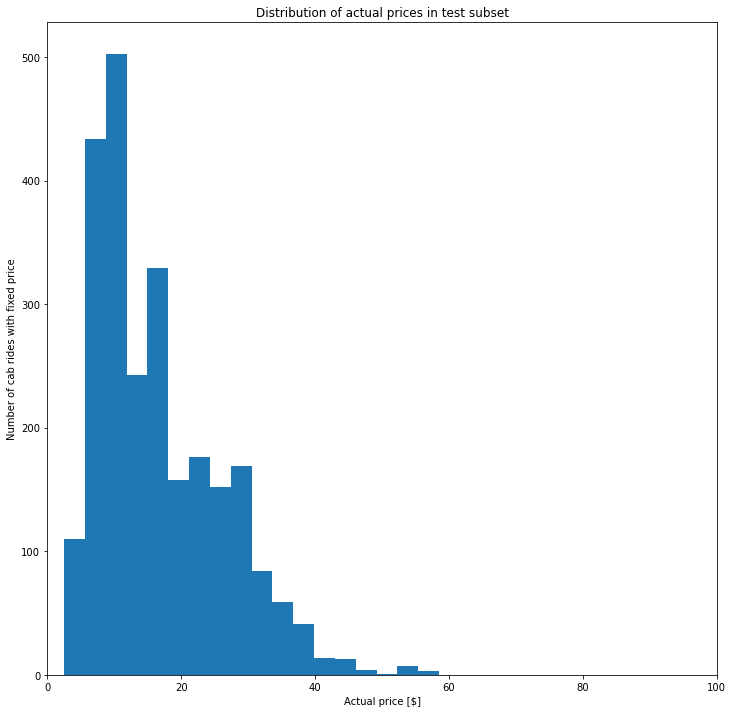

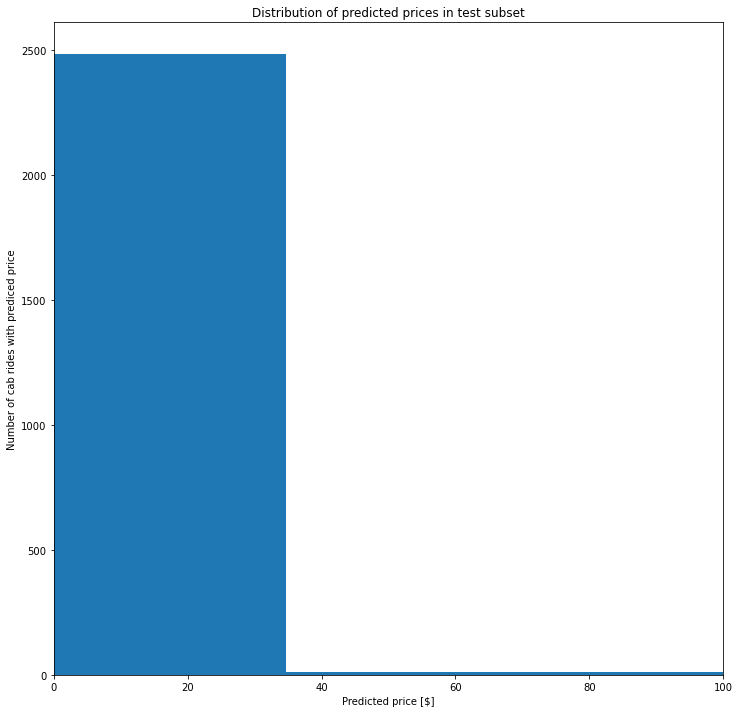

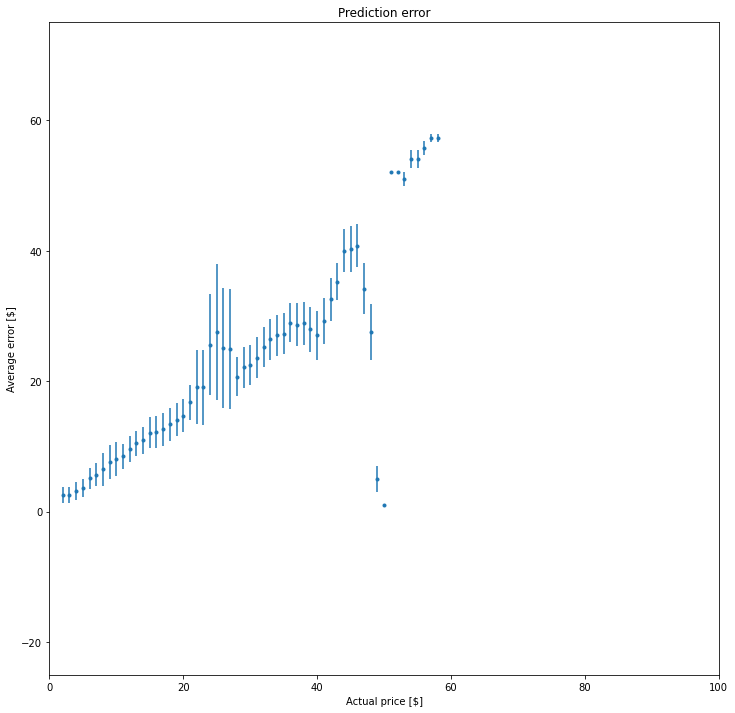

In [147]:
gaussian_regression_model_condition(size=10000, do_draw_results=False, do_analyze_error=True)

## Simple neural network model

In [173]:
best_n, best_epoch, best_layer_n = 50, 10, 1
# best_n, best_epoch, best_layer_n = find_best_nn_condition()

In [174]:
nn_regression_model_condition(n = best_n, epochs = best_epoch, layer_n = best_layer_n)

Epoch 1/10
15950/15950 [==============================] - 25s 2ms/step - loss: 11.4895 - mae: 1.8218
Epoch 2/10
15950/15950 [==============================] - 25s 2ms/step - loss: 3.2330 - mae: 1.2045
Epoch 3/10
15950/15950 [==============================] - 24s 2ms/step - loss: 3.1837 - mae: 1.1937
Epoch 4/10
15950/15950 [==============================] - 24s 2ms/step - loss: 3.1590 - mae: 1.1898
Epoch 5/10
15950/15950 [==============================] - 25s 2ms/step - loss: 3.1315 - mae: 1.1824
Epoch 6/10
15950/15950 [==============================] - 27s 2ms/step - loss: 3.1150 - mae: 1.1787
Epoch 7/10
15950/15950 [==============================] - 26s 2ms/step - loss: 3.1007 - mae: 1.1765
Epoch 8/10
15950/15950 [==============================] - 29s 2ms/step - loss: 3.0950 - mae: 1.1746
Epoch 9/10
15950/15950 [==============================] - 26s 2ms/step - loss: 3.0881 - mae: 1.1713
Epoch 10/10
3988/3988 [==============================] - 6s 1ms/step - loss: 3.0176 - mae: 1.1617
T

Prediction score square sum = 1.7371117893128087
actual price =  7.00 predicted price =  6.55
actual price = 34.00 predicted price = 36.34
actual price = 19.50 predicted price = 20.54
actual price =  7.50 predicted price =  8.01
actual price = 16.00 predicted price = 17.63
actual price = 17.50 predicted price = 19.13
actual price = 18.00 predicted price = 17.97
actual price =  9.00 predicted price =  8.87
actual price = 32.50 predicted price = 30.33
actual price =  7.50 predicted price =  8.15
actual price = 27.50 predicted price = 27.34
actual price =  8.00 predicted price =  8.15
actual price =  7.50 predicted price =  7.22
actual price = 22.50 predicted price = 24.17
actual price = 33.00 predicted price = 33.72
actual price =  3.00 predicted price =  4.03
actual price = 15.00 predicted price = 15.29
actual price = 10.00 predicted price =  9.27
actual price = 29.00 predicted price = 27.65
actual price = 16.50 predicted price = 17.73
actual price = 27.50 predicted price = 27.11
actual

Epoch 1/10
15950/15950 [==============================] - 23s 1ms/step - loss: 14.2885 - mae: 1.9462
Epoch 2/10
15950/15950 [==============================] - 25s 2ms/step - loss: 3.3100 - mae: 1.2220
Epoch 3/10
15950/15950 [==============================] - 28s 2ms/step - loss: 3.2331 - mae: 1.2060
Epoch 4/10
15950/15950 [==============================] - 28s 2ms/step - loss: 3.2060 - mae: 1.2005
Epoch 5/10
15950/15950 [==============================] - 28s 2ms/step - loss: 3.1910 - mae: 1.1956
Epoch 6/10
15950/15950 [==============================] - 28s 2ms/step - loss: 3.1797 - mae: 1.1925
Epoch 7/10
15950/15950 [==============================] - 27s 2ms/step - loss: 3.1733 - mae: 1.1899
Epoch 8/10
15950/15950 [==============================] - 28s 2ms/step - loss: 3.1692 - mae: 1.1894
Epoch 9/10
15950/15950 [==============================] - 27s 2ms/step - loss: 3.1629 - mae: 1.1881
Epoch 10/10
3988/3988 [==============================] - 5s 1ms/step


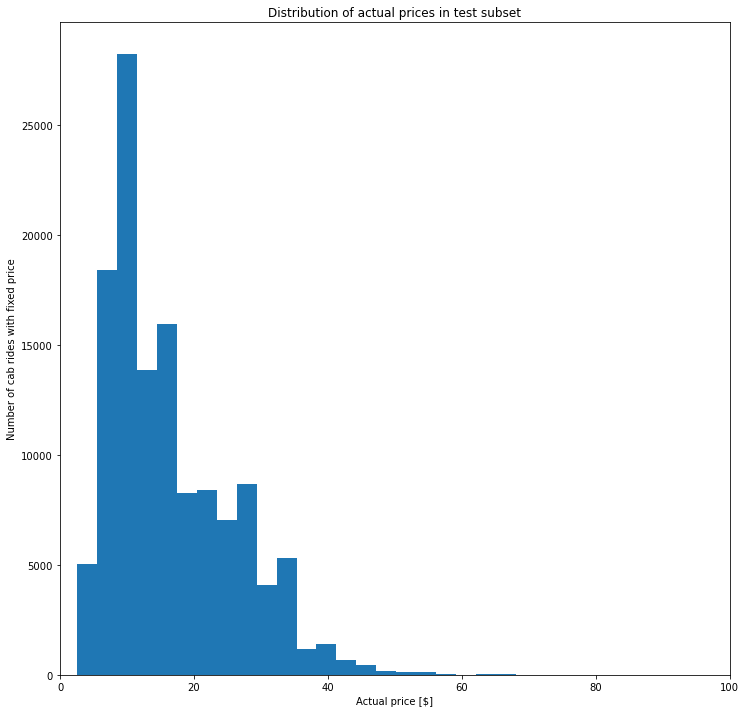

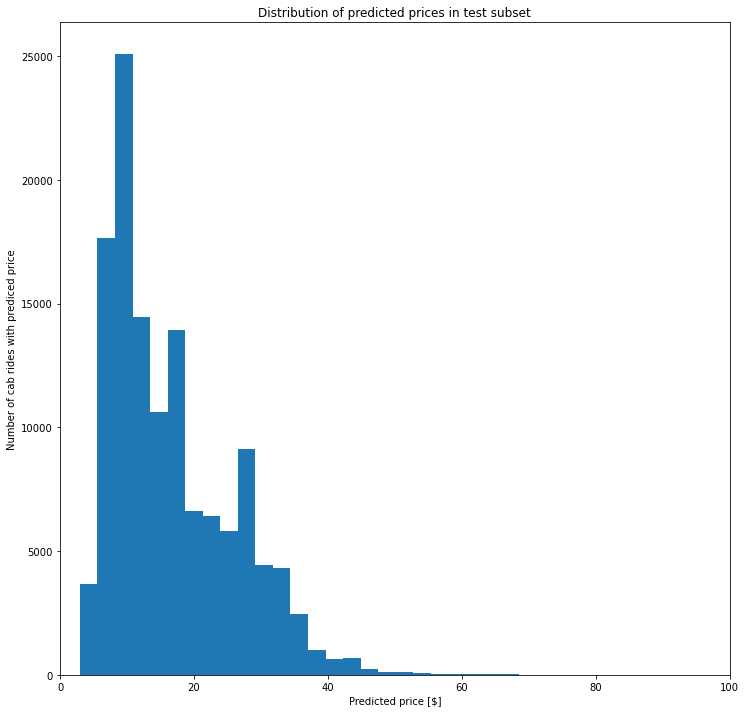

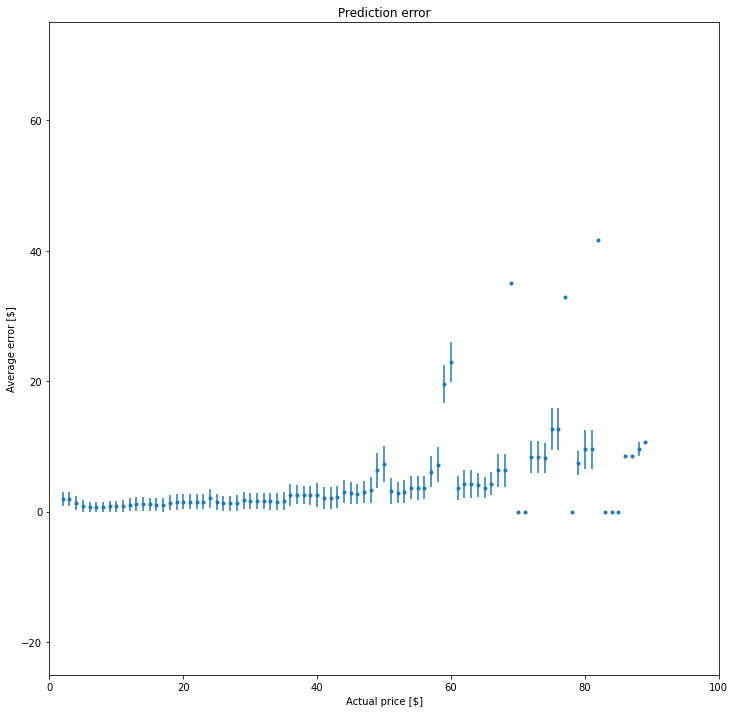

In [175]:
nn_regression_model_condition(n = best_n, epochs = best_epoch, layer_n = best_layer_n, do_draw_results=False, do_analyze_error=True)